In [1]:
!pip install tables
!pip install mplsoccer

     |████████████████████████████████| 5.9 MB 4.3 MB/s            
     |████████████████████████████████| 58 kB 1.8 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for mplsoccer: filename=mplsoccer-1.0.6-py3-none-any.whl size=62946 sha256=32ba4a1b8f5289ecaa46966f723d227b0bc249d47c2fb9a3d880fa5ff6e1da02
  Stored in directory: /root/.cache/pip/wheels/ff/fc/ed/09e6cb7c61780f5462f1dfd1df7d1fabef0123ced961ac0738
Successfully built mplsoccer


In [2]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 4.3 MB/s            
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=3428485 sha256=6f4c2a03890b1e82da0b3224e110d4bb9f528bb28398d092f5bb8afa23e429c5
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import bz2
from glob import glob
import imageio
import json
import os

In [4]:
def create_pitch(length, width, linecolor, bounds = 15):

    """
    mainly stolen from fc python
    param length: an int the length of the field
    param width: an int the height of the field
    param linecolor: the color of the lines
"""
    #Create figure
    fig=plt.figure()
    #fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,width], color=linecolor)
    plt.plot([0,length],[width,width], color=linecolor)
    plt.plot([length,length],[width,0], color=linecolor)
    plt.plot([length,0],[0,0], color=linecolor)
    plt.plot([length/2,length/2],[0,width], color=linecolor)
    plt.fill_between(x = [-bounds, length+bounds],
                     y1 = [width+bounds, width + bounds],
                     y2 = [-bounds, -bounds], color='green')

    #Left Penalty Area
    plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Right Penalty Area
    plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Left 5-meters Box
    plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
    plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)

    #Right 5-meters Box
    plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
    plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)

    #Prepare Circles
    centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
    rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
    rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
            #Axis titles
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [5]:
data_path = '../input/socceranalytics/events/events/'
team = 'Italy'
json_matches_path = '../input/socceranalytics/matches.json'

def all_matches(team, data_path):
    match_ids = get_all_matchids(team)
    all_team_df, dfs = get_all_matchdfs(match_ids, data_path)
    return all_team_df, dfs

def get_all_matchids(team):
    '''
    given a team name i.e. "Italy", returns a list of all match_ids by italy
    '''
    with open(json_matches_path) as f:
        data = json.load(f)
        matches = pd.json_normalize(data, sep = "_")
    #get mask for team
    mask = (matches["home_team_home_team_name"] == team) | (matches["away_team_away_team_name"] == team)
    team_matches = matches[mask]
    match_ids = []
    for match in team_matches.match_id:
        match_ids.append(match)
    return match_ids

def get_all_matchdfs(match_ids, data_path):
    '''
    takes a list of matches and a datapath to all match_data and returns
    a concatenated dataframe + a dictionary of dataframes 
    with all dataframes for those match_ids
    param: match_ids, list of strings match_ids
    param: data_path, string, path to json files
    '''
    dfs = dict()
    for match_id in match_ids:
        zipfile = bz2.BZ2File(data_path + f"{match_id}.json.bz2")
        file = zipfile.read()
        open(f"{match_id}.json", 'wb').write(file)
        with open(f"{match_id}.json") as f:
            events = json.load(f)
            df = pd.json_normalize(events[2:], sep = "_")
            df['match_id'] = match_id
            dfs[match_id] = df
    match_dfs = []
    for key, df in dfs.items():
        match_dfs.append(df)
    return pd.concat(match_dfs), dfs

In [6]:
def time_to_mins(timestring):
    minute = list(map(float, timestring.split(":")))[1]
    return minute

In [7]:
all_italy_df, dfs = all_matches('Italy', data_path)

In [8]:
all_wales_df, dfs_w = all_matches('Wales', data_path)

In [9]:
with open('../input/socceranalytics/matches.json') as f:
    data = json.load(f)
    matches = pd.json_normalize(data, sep = "_")
    
to_drop = ['away_team_away_team_gender',
           'home_team_home_team_gender',
           'competition_country_name',
           'competition_competition_id',
           'last_updated_360',
           'last_updated',
           'season_season_name',
           'competition_competition_name',
           'competition_competition_id',
           'match_status',
           'metadata_shot_fidelity_version',
           'match_week']
matches = matches.drop(to_drop, axis=1)

In [10]:
matches.head()

,match_id,match_date,kick_off,home_score,away_score,match_status_360,season_season_id,home_team_home_team_id,home_team_home_team_name,home_team_home_team_group,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,3788753,2021-06-16,15:00:00.000,0,1,available,43,1835,Finland,Group B,...,10,Group Stage,4726,Saint-Petersburg Stadium,188,Russia,293,Danny Desmond Makkelie,160,Netherlands
1,3788765,2021-06-20,18:00:00.000,3,1,available,43,773,Switzerland,Group A,...,10,Group Stage,4549,Bakı Olimpiya Stadionu,16,Azerbaijan,943,Slavko Vinčić,208,Slovenia
2,3795107,2021-07-02,21:00:00.000,1,2,available,43,782,Belgium,None,...,11,Quarter-finals,4867,Allianz Arena (München),85,Germany,943,Slavko Vinčić,208,Slovenia
3,3795221,2021-07-07,21:00:00.000,2,1,available,43,768,England,None,...,15,Semi-finals,4666,Wembley Stadium (London),68,England,293,Danny Desmond Makkelie,160,Netherlands
4,3795506,2021-07-11,21:00:00.000,1,1,available,43,914,Italy,None,...,26,Final,4666,Wembley Stadium (London),68,England,287,Björn Kuipers,160,Netherlands


In [11]:
#drop 0 variance columns
matches.loc[:, (matches != matches.iloc[0]).any()].shape

(51, 27)

In [12]:
mask = (matches["home_team_home_team_name"] == "Italy") | (matches["away_team_away_team_name"] == "Italy")
italy_matches = matches[mask]
mask = (matches["home_team_home_team_name"] == "Wales") | (matches["away_team_away_team_name"] == "Wales")
wales_matches = matches[mask]

In [13]:
italy_match_ids = []
wales_match_ids = []
for match in italy_matches.match_id:
    italy_match_ids.append(match)
for match in wales_matches.match_id:
    wales_match_ids.append(match)

In [14]:
data_path = '../input/socceranalytics/events/events'
files = glob(data_path +'/*.json.bz2')

In [15]:
bins = [i for i in range(0, 130, 5)]
all_italy_df['minute_bins'] = pd.cut(all_italy_df.minute + 1, bins = bins, labels = bins.append(130), retbins = True)[0].apply(lambda x: x.right)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [16]:
all_italy_df.minute_bins

0         5
1         5
2         5
3         5
4         5
       ... 
4820    130
4821    130
4822    130
4823    130
4824    130
Name: minute_bins, Length: 28869, dtype: category
Categories (26, int64): [5 < 10 < 15 < 20 ... 115 < 120 < 125 < 130]

In [17]:
def restore_df(path):
    with pd.HDFStore(path, mode = 'r') as store:
        df = store.get('df')
        df.attrs = store.get_storer('df').attrs.my_attribute
        return df

In [18]:
iw_track = restore_df("../input/socceranalytics/dfmeta/dfmeta/italyvwales.h5")
player_map = iw_track.attrs['player_map']
pos_cols = [col for col in iw_track if 'x' in col or 'y' in col]

In [19]:
for key in player_map.keys():
    try:
        iw_track[str(key) + "_distance"] = (iw_track[str(key) + "_x"] - iw_track['ball_x'])**2
        iw_track[str(key) + "_distance"] += (iw_track[str(key) + "_y"] - iw_track['ball_y'])**2
        iw_track[str(key) + "_distance"] = iw_track[str(key) + "_distance"].apply(np.sqrt)
    except:
        print(f"{player_map[key]} did not play")

Alex Meret did not play
Giovanni Di Lorenzo did not play
Giorgio Chiellini did not play
Leonardo Spinazzola did not play
Alessandro Florenzi did not play
Manuel Locatelli did not play
Nicolò Barella did not play
Lorenzo Insigne did not play
Domenico Berardi did not play
Ciro Immobile did not play
Wayne Hennessey did not play
Adam Davies did not play
Tom Lockyer did not play
Rhys Norrington-Davies did not play
Chris Mepham did not play
Ben Cabango did not play
Jonny Williams did not play
Rubin Colwill did not play
Matthew Smith did not play
Tyler Roberts did not play


In [20]:
import mplsoccer.statsbomb as sbapi

In [21]:
match_id = "3788766"
zipfile = bz2.BZ2File(data_path + f"/{match_id}.json.bz2")
file = zipfile.read()
open(f"{match_id}.json", 'wb').write(file)
dict_event = sbapi.read_event(f"{match_id}.json", warn = False)
df_event = dict_event['event']
df_related_event = dict_event['related_event']
df_shot_freeze = dict_event['shot_freeze_frame']
df_tactics_lineup = dict_event['tactics_lineup']

In [22]:
df_event.columns

Index(['match_id', 'id', 'index', 'period', 'timestamp_minute',
       'timestamp_second', 'timestamp_millisecond', 'minute', 'second',
       'type_id', 'type_name', 'sub_type_id', 'sub_type_name', 'outcome_id',
       'outcome_name', 'play_pattern_id', 'play_pattern_name',
       'possession_team_id', 'possession', 'possession_team_name', 'team_id',
       'team_name', 'player_id', 'player_name', 'position_id', 'position_name',
       'duration', 'x', 'y', 'z', 'end_x', 'end_y', 'end_z', 'body_part_id',
       'body_part_name', 'technique_id', 'technique_name', 'under_pressure',
       'counterpress', 'off_camera', 'out', 'pass_length', 'pass_angle',
       'pass_recipient_id', 'pass_recipient_name', 'pass_height_id',
       'pass_height_name', 'pass_switch', 'pass_cross',
       'pass_assisted_shot_id', 'pass_shot_assist', 'pass_cut_back',
       'pass_goal_assist', 'ball_recovery_recovery_failure',
       'block_deflection', 'dribble_nutmeg', 'foul_committed_advantage',
       'fou

In [23]:
interest = ['period', 'timestamp_minute',
       'timestamp_second', 'minute', 'second',
       'sub_type_name',
       'outcome_name', 'play_pattern_name','possession', 'possession_team_name',
       'team_name', 'player_name', 'position_name',
       'duration', 'x', 'y', 'end_x', 'end_y',
       'body_part_name', 'technique_name', 'under_pressure', 'off_camera', 'out', 'pass_length', 'pass_angle',
       'pass_recipient_name',
       'pass_height_name', 'pass_switch', 'pass_cross', 'pass_shot_assist', 'pass_cut_back',
       'pass_goal_assist']

In [24]:
passy = df_event[df_event.type_name =='Pass'][interest]

In [25]:
# true if forward pass, false otherwise
passy['direction'] = (passy['x'] - passy['end_x']) < 0
passy = passy.sort_values(by = ['possession', 'minute', 'second'])
passy['p_count'] = passy.groupby('possession').transform('cumcount') + 1

In [26]:
passy.possession_team_name.unique()

array(['Italy', 'Wales'], dtype=object)

In [27]:
ipasses = passy[passy['possession_team_name'] == 'Italy']
wpasses = passy[passy['possession_team_name'] == 'Wales']

In [28]:
passy.duration.sum()

1363.886246

In [29]:
passy[passy.under_pressure == 1]

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_angle,pass_recipient_name,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count
24,1,0,18,0,18,NaN,Incomplete,From Kick Off,2,Italy,...,-0.411521,Daniel James,High Pass,NaN,NaN,NaN,NaN,NaN,True,7
43,1,1,21,1,21,Recovery,NaN,Regular Play,4,Italy,...,0.509438,Andrea Belotti,High Pass,NaN,NaN,NaN,NaN,NaN,True,1
91,1,2,11,2,11,NaN,NaN,Regular Play,4,Italy,...,0.883125,Federico Chiesa,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,18
95,1,2,12,2,12,NaN,NaN,Regular Play,4,Italy,...,-2.612003,Andrea Belotti,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,19
121,1,2,40,2,40,NaN,NaN,From Free Kick,6,Wales,...,0.490781,Gareth Frank Bale,Low Pass,NaN,NaN,NaN,NaN,NaN,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,2,36,31,81,31,NaN,NaN,From Free Kick,148,Italy,...,-1.864666,Matteo Pessina,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,20
2798,2,37,22,82,22,Recovery,NaN,From Free Kick,148,Italy,...,0.451453,Federico Chiesa,Ground Pass,NaN,NaN,True,NaN,NaN,True,34
2831,2,38,55,83,55,Recovery,NaN,From Corner,150,Italy,...,0.000000,Giacomo Raspadori,High Pass,NaN,NaN,NaN,NaN,NaN,True,6
2925,2,42,51,87,51,Recovery,NaN,From Throw In,152,Italy,...,-0.986352,Federico Chiesa,High Pass,NaN,NaN,NaN,NaN,NaN,True,22


In [30]:
italy_wales = dfs[3788766]

In [31]:
iw_passes = italy_wales[italy_wales.type_name =='Pass']
pass_cols = [col for col in italy_wales.columns if "pass" in col] + ['player_name', 'under_pressure', 'team_name']

In [32]:
pass_cols

['pass_recipient_id',
 'pass_recipient_name',
 'pass_length',
 'pass_angle',
 'pass_height_id',
 'pass_height_name',
 'pass_end_location',
 'pass_type_id',
 'pass_type_name',
 'pass_body_part_id',
 'pass_body_part_name',
 'pass_outcome_id',
 'pass_outcome_name',
 'pass_aerial_won',
 'pass_switch',
 'pass_cross',
 'pass_assisted_shot_id',
 'pass_shot_assist',
 'shot_key_pass_id',
 'pass_inswinging',
 'pass_technique_id',
 'pass_technique_name',
 'pass_cut_back',
 'pass_outswinging',
 'pass_through_ball',
 'pass_goal_assist',
 'player_name',
 'under_pressure',
 'team_name']

In [33]:
cluster_cols = ['x', 'y','end_x', 'end_y', 'pass_length']

In [34]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 3)
clusterer.fit(ipasses[cluster_cols])

HDBSCAN(min_cluster_size=10, min_samples=3)

In [35]:
clusterer.labels_

array([ 5, -1,  4, -1, -1, -1, -1, -1, -1,  5, -1, -1,  5, -1, -1, -1, -1,
        5,  5, -1,  5,  5,  5,  5,  5,  5, -1, -1,  5,  5, -1,  0,  1,  3,
       -1, -1, -1, -1, -1, -1, -1,  5,  5,  5,  5,  5, -1,  5, -1, -1, -1,
       -1, -1,  5,  5, -1,  2,  3,  3,  5, -1, -1, -1, -1,  4,  5,  2, -1,
       -1,  5, -1, -1,  3, -1, -1, -1,  5,  5,  5,  5,  1, -1,  4, -1,  4,
       -1,  5,  5,  5,  5, -1, -1,  1,  1,  1, -1, -1,  2,  5,  5,  5,  5,
        5,  5,  5, -1, -1, -1,  5,  5,  5,  5,  5,  5,  5,  5, -1,  3,  3,
       -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1,  5, -1, -1, -1,  1, -1,
       -1,  5,  5,  5,  5, -1,  5,  2,  5, -1, -1, -1, -1,  5,  5, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  1, -1,  0,  0, -1, -1,  0, -1, -1,
       -1,  5, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1,  0,
       -1, -1, -1, -1,  5, -1,  5,  5,  5,  5, -1, -1, -1,  5,  5,  5, -1,
        5, -1,  3,  3, -1, -1, -1, -1, -1,  0, -1, -1,  5,  5,  5,  5,  2,
       -1, -1, -1,  5,  1

In [36]:
ipasses['cluster'] = clusterer.labels_
clusters_italy = ipasses.groupby('cluster')[cluster_cols].mean()
clusters_italy['x']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


cluster
-1    59.471972
 0    12.844444
 1    39.533333
 2    53.850000
 3    84.785915
 4    36.190909
 5    66.635961
Name: x, dtype: float64

In [37]:
clusters_italy

,x,y,end_x,end_y,pass_length
cluster,,,,,
-1,59.471972,39.908997,65.126298,39.219377,24.861361
0,12.844444,37.044444,20.038889,52.394444,19.191307
1,39.533333,65.653333,40.700000,67.073333,15.331195
2,53.850000,46.875000,66.566667,72.458333,28.977252
3,84.785915,69.012676,88.171831,70.107042,13.852561
4,36.190909,39.345455,40.181818,25.554545,15.522843
5,66.635961,22.472414,66.377340,23.596059,15.350287


In [38]:
sns.set(rc={'figure.figsize':(20,15)})

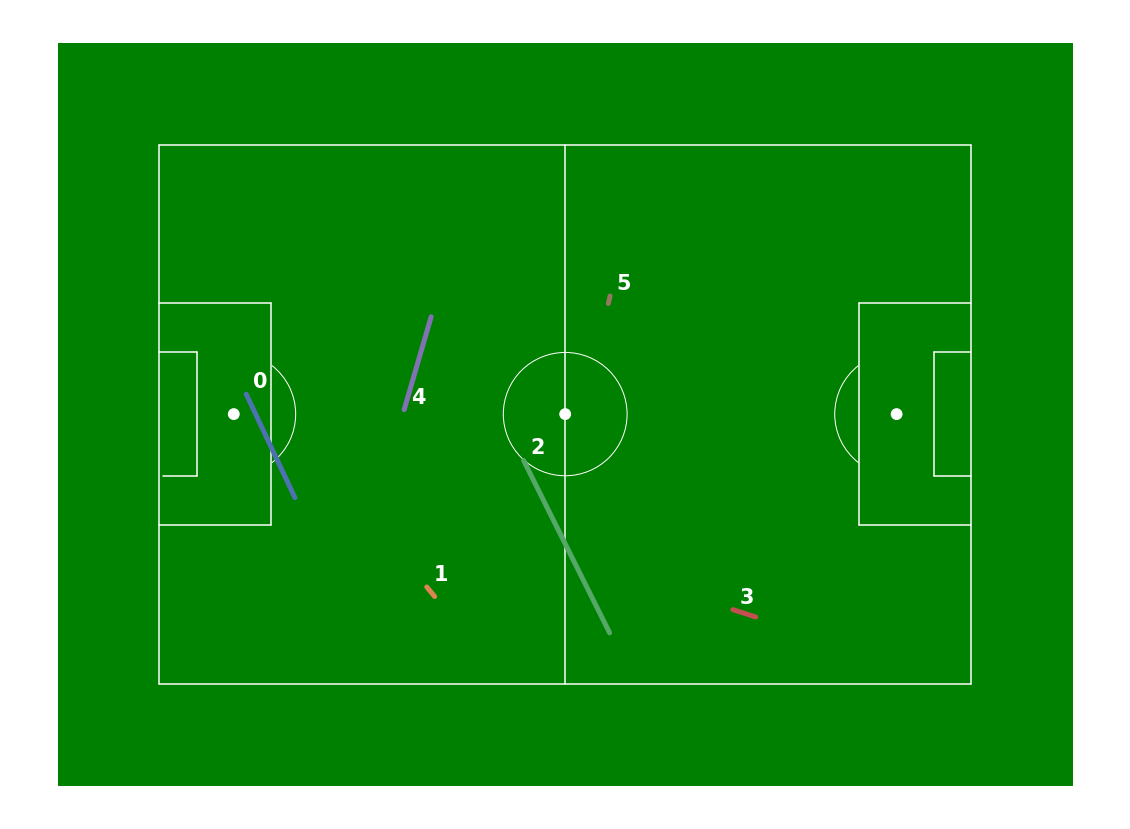

In [39]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_italy.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 5)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig("dbscan_cluster.png")

In [40]:
ipasses[ipasses['cluster'] == 5][['player_name', 'pass_recipient_name']].value_counts()[:5]

player_name                  pass_recipient_name  
Alessandro Bastoni           Marco Verratti           15
Emerson Palmieri dos Santos  Marco Verratti           15
Marco Verratti               Alessandro Bastoni       14
Emerson Palmieri dos Santos  Alessandro Bastoni       12
Marco Verratti               Federico Bernardeschi    10
dtype: int64

In [41]:
ipasses[ipasses['cluster'] == 2][['player_name', 'pass_recipient_name']].value_counts()[:5]

player_name       pass_recipient_name
Francesco Acerbi  Rafael Tolói           4
Leonardo Bonucci  Rafael Tolói           3
Bryan Cristante   Rafael Tolói           2
                  Francesco Acerbi       1
Leonardo Bonucci  Matteo Pessina         1
dtype: int64

In [42]:
ipasses.groupby('cluster').first()

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_angle,pass_recipient_name,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count
cluster,,,,,,,,,,,,,,,,,,,,,
-1,1,0,4,0,4,Recovery,Incomplete,From Kick Off,2,Italy,...,3.039149,Leonardo Bonucci,Ground Pass,True,True,True,None,True,False,2
0,1,3,28,3,28,Recovery,None,Regular Play,8,Italy,...,1.443930,Leonardo Bonucci,Ground Pass,None,None,None,None,None,True,2
1,1,3,35,3,35,Throw-in,Out,Regular Play,8,Italy,...,1.161692,Rafael Tolói,Ground Pass,None,None,None,None,None,True,3
2,1,6,18,6,18,None,None,From Free Kick,14,Italy,...,1.055942,Rafael Tolói,Ground Pass,None,None,None,None,None,True,5
3,1,3,39,3,39,Recovery,Incomplete,Regular Play,8,Italy,...,-0.798911,Andrea Belotti,Ground Pass,None,True,True,True,None,True,4
4,1,0,5,0,5,None,None,From Kick Off,2,Italy,...,-1.412706,Alessandro Bastoni,Ground Pass,None,None,None,None,None,True,3
5,1,0,0,0,0,Kick Off,Incomplete,From Kick Off,2,Italy,...,2.884269,Jorge Luiz Frello Filho,Ground Pass,None,None,True,None,None,False,1


In [43]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=20,
                              random_state=42,
                              max_iter = 1000,
                              init_params = 'kmeans').fit(ipasses[cluster_cols])

In [44]:
ipasses['gmm_cluster'] = bgm.predict(ipasses[cluster_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
clusters_italy2 = ipasses.groupby('gmm_cluster').mean()[cluster_cols]

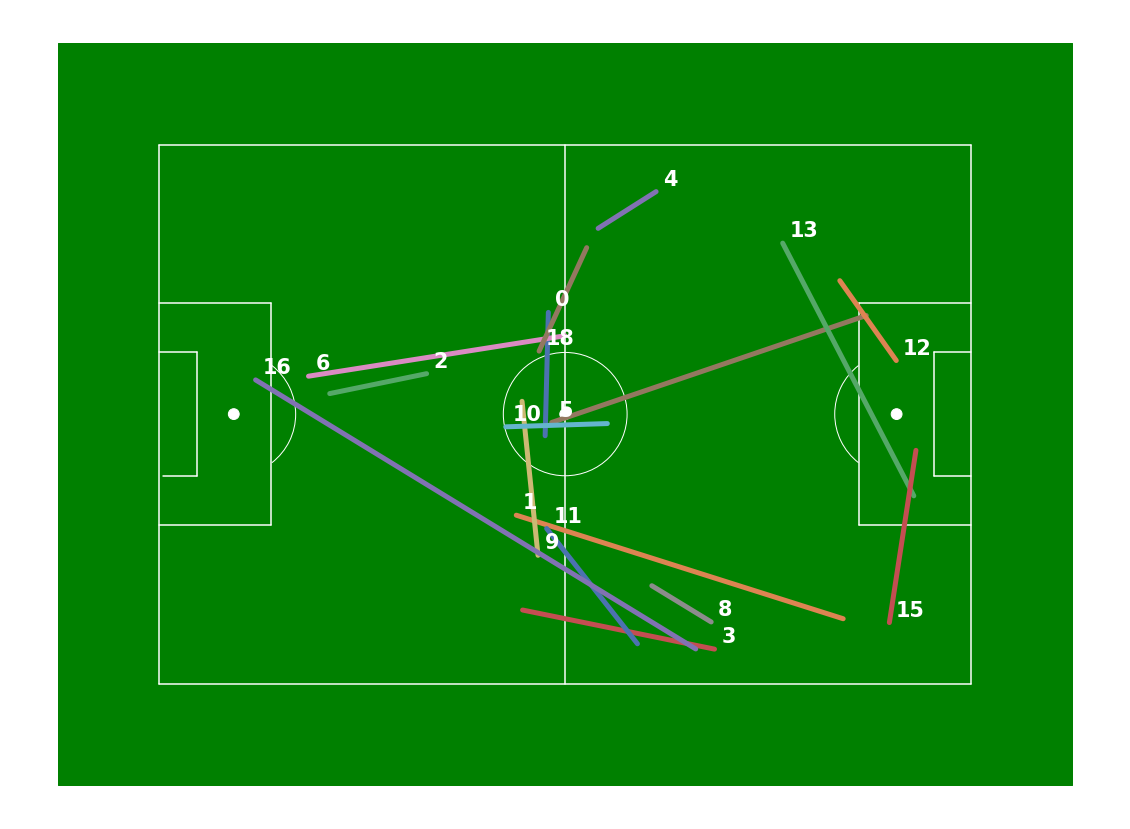

In [46]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_italy2.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 5)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig('gmm_cluster.png')

In [47]:
ipasses[ipasses['gmm_cluster'] == 4][['player_name', 'pass_recipient_name']].value_counts()[:5]

player_name                  pass_recipient_name
Emerson Palmieri dos Santos  Alessandro Bastoni     18
                             Marco Verratti         11
Alessandro Bastoni           Marco Verratti          9
Marco Verratti               Alessandro Bastoni      6
Federico Bernardeschi        Marco Verratti          6
dtype: int64

### Cluster 5 is neither forward nor backwards cluster
### Italy rarely pass back to the keeper too

In [48]:
ipasses.groupby(['cluster', 'direction']).size()

cluster  direction
-1       False        115
         True         174
 0       False          3
         True          15
 1       False         12
         True          18
 2       True          12
 3       False         33
         True          38
 4       False          2
         True           9
 5       False        103
         True         100
dtype: int64

In [49]:
cluster5 = ipasses[(ipasses['cluster'] == 5) & (ipasses['play_pattern_name'] == 'Regular Play')]
color_labels = cluster5.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

In [50]:
color_map[color_labels[0]]

(0.4, 0.7607843137254902, 0.6470588235294118)

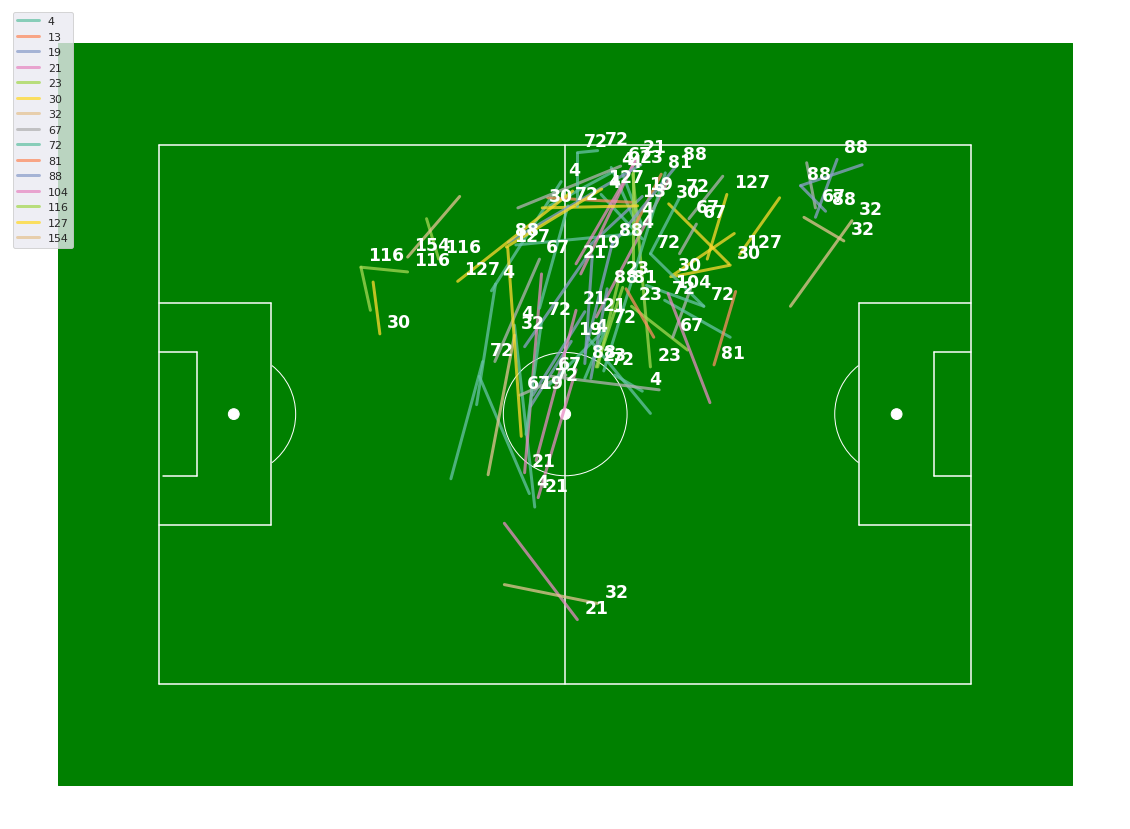

In [51]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_poss_group.png')

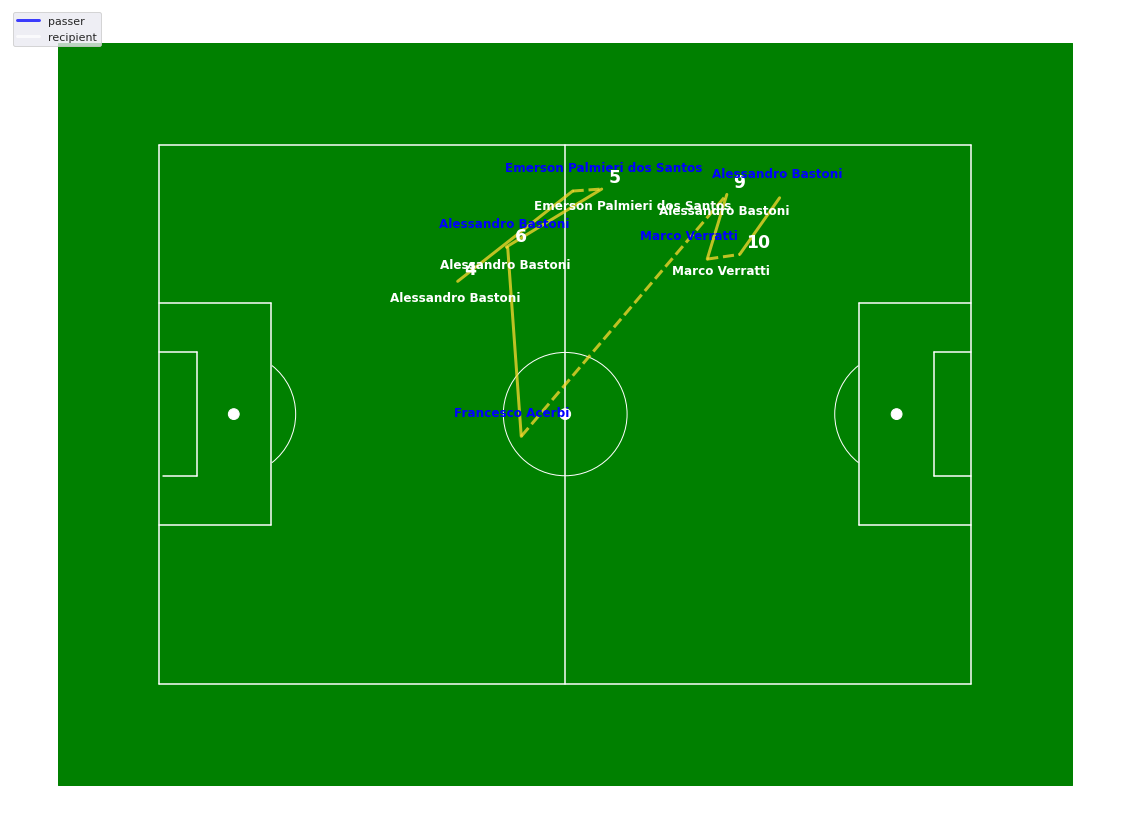

In [52]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0) or (pass_.possession != 127):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_127.png')

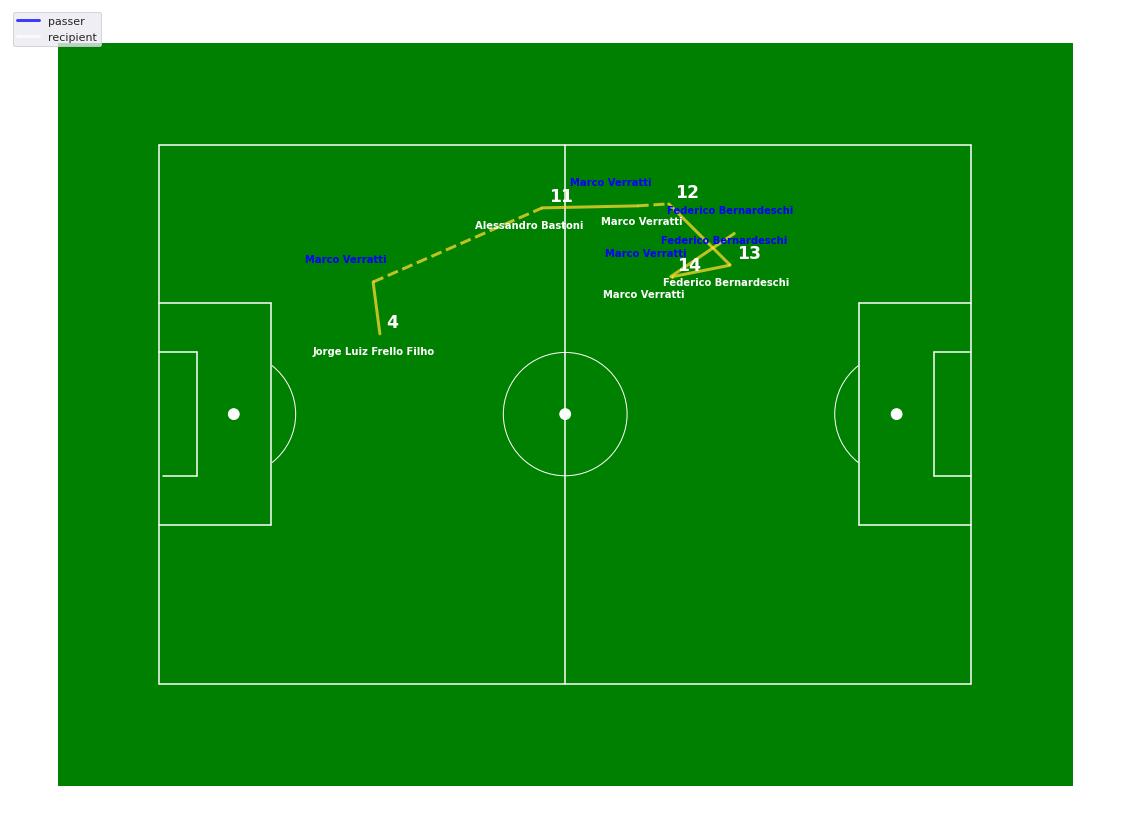

In [53]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0) or (pass_.possession != 30):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'small')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'small')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_30.png')

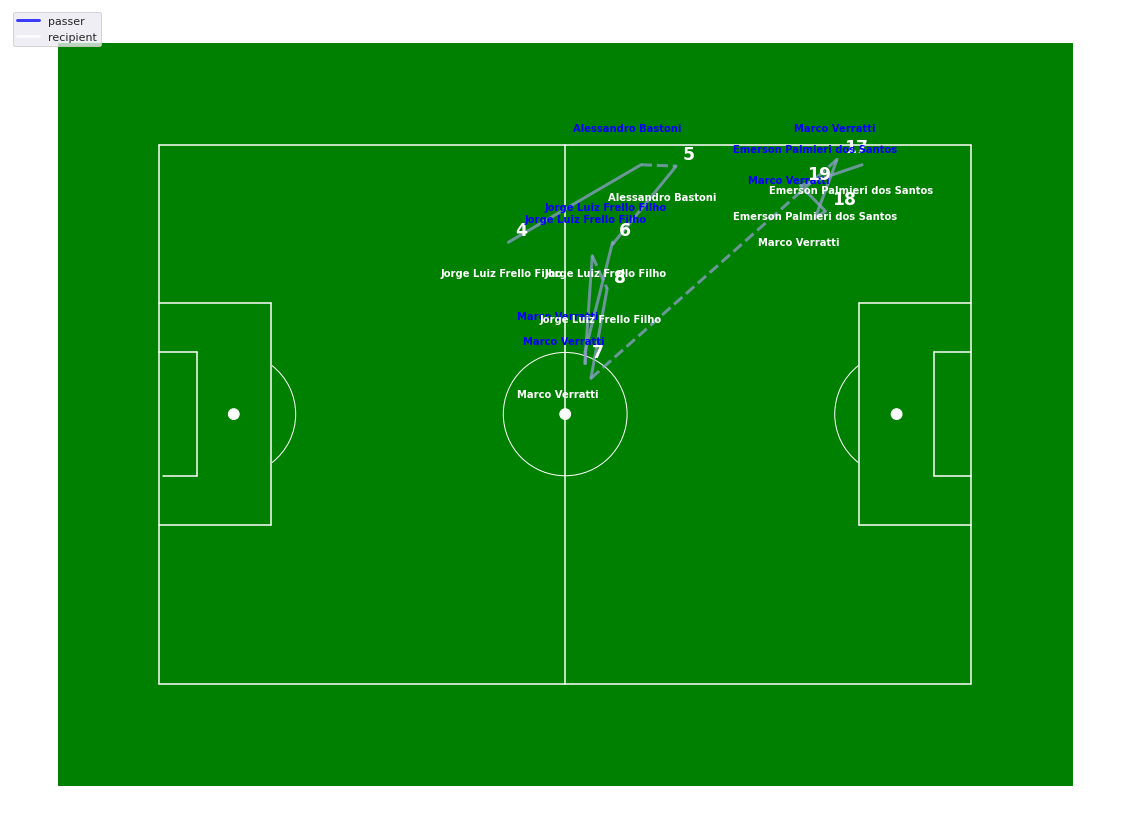

In [54]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0) or (pass_.possession != 88):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-5,pass_.player_name, color = "white", fontweight = 'semibold', fontsize = 'small')
    plt.text((end_x-10),end_y+5,pass_.pass_recipient_name, color = "blue", fontweight = 'semibold', fontsize = 'small')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_88.png')

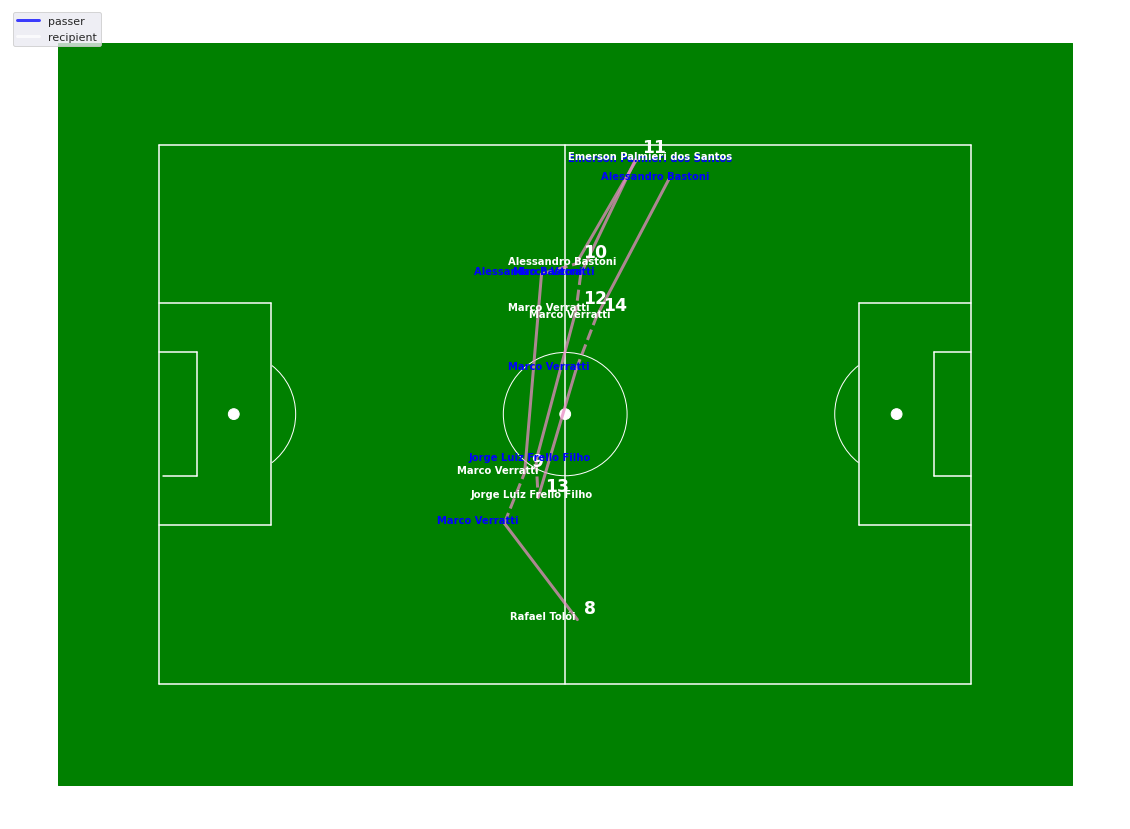

In [55]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0) or (pass_.possession != 21):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y,pass_.player_name, color = "white", fontweight = 'semibold', fontsize = 'small')
    plt.text((end_x-10),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'semibold', fontsize = 'small')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_21.png')

In [56]:
cluster5[cluster5.possession == 30]

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count,cluster,gmm_cluster
561,1,14,50,14,50,NaN,NaN,Regular Play,30,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,4,5,18
587,1,15,15,15,15,NaN,NaN,Regular Play,30,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,11,5,10
590,1,15,17,15,17,NaN,NaN,Regular Play,30,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,12,5,0
593,1,15,18,15,18,NaN,NaN,Regular Play,30,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,13,5,4
597,1,15,19,15,19,NaN,NaN,Regular Play,30,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,14,5,18


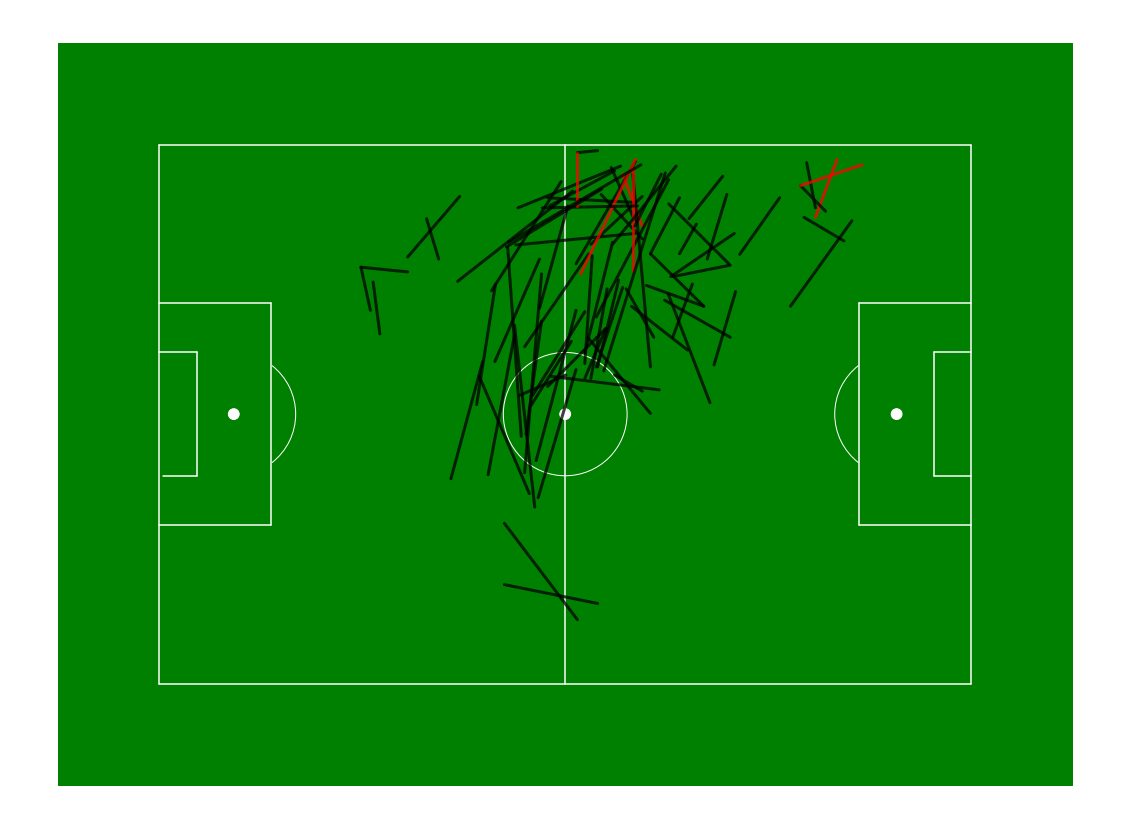

In [57]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    if pass_.player_name == "Emerson Palmieri dos Santos" and pass_.pass_recipient_name == "Marco Verratti":
        color = 'red' 
    else:
        color = 'black'
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color= color)
    #plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig('cluster4.png')

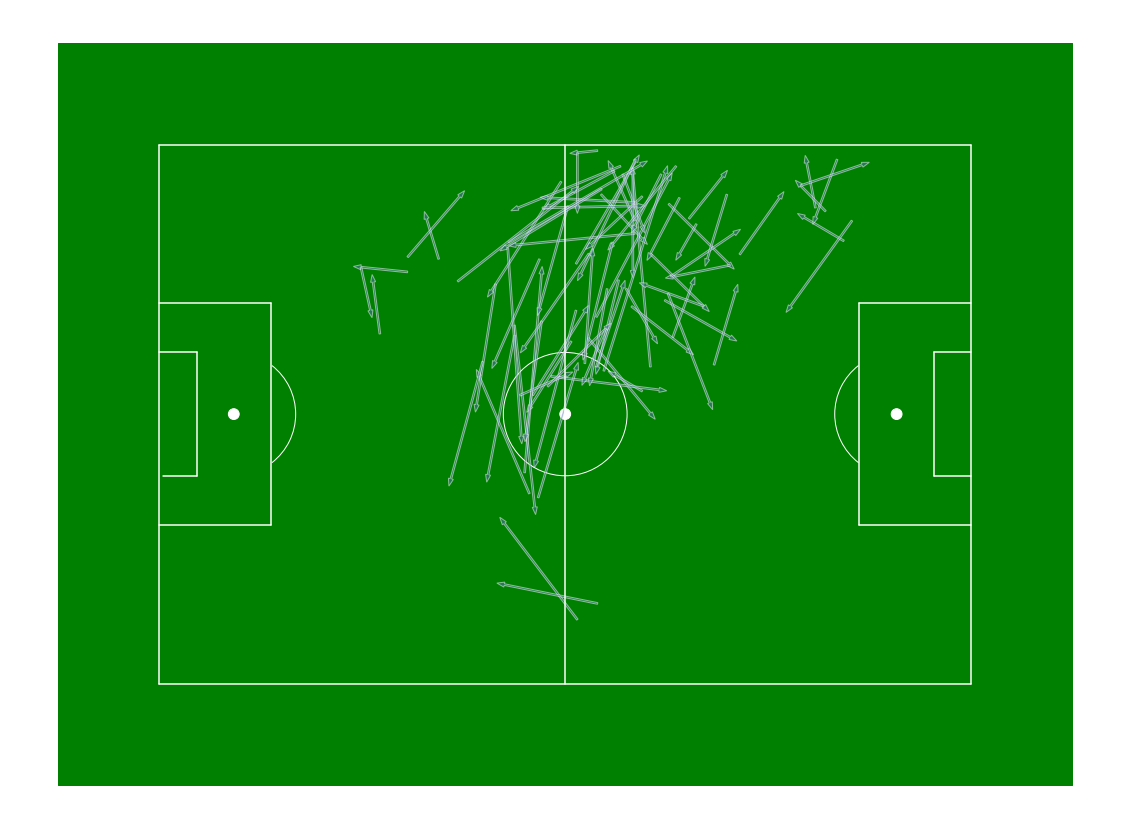

In [58]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.arrow(x, y, (end_x - x), (end_y - y), width = 0.25, alpha = 0.5)
    #plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig('cluster4arrow.png')

In [59]:
cluster5

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count,cluster,gmm_cluster
45,1,1,23,1,23,NaN,NaN,Regular Play,4,Italy,...,Low Pass,NaN,NaN,NaN,NaN,NaN,False,2,5,9
60,1,1,39,1,39,NaN,NaN,Regular Play,4,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,7,5,4
63,1,1,41,1,41,NaN,NaN,Regular Play,4,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,8,5,0
69,1,1,49,1,49,NaN,NaN,Regular Play,4,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,10,5,4
71,1,1,49,1,49,NaN,NaN,Regular Play,4,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,2,21,15,66,15,NaN,NaN,Regular Play,127,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,5,5,4
2342,2,21,17,66,17,NaN,NaN,Regular Play,127,Italy,...,Low Pass,NaN,NaN,NaN,NaN,NaN,True,6,5,0
2356,2,21,37,66,37,NaN,NaN,Regular Play,127,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,9,5,4
2359,2,21,41,66,41,NaN,NaN,Regular Play,127,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,10,5,18


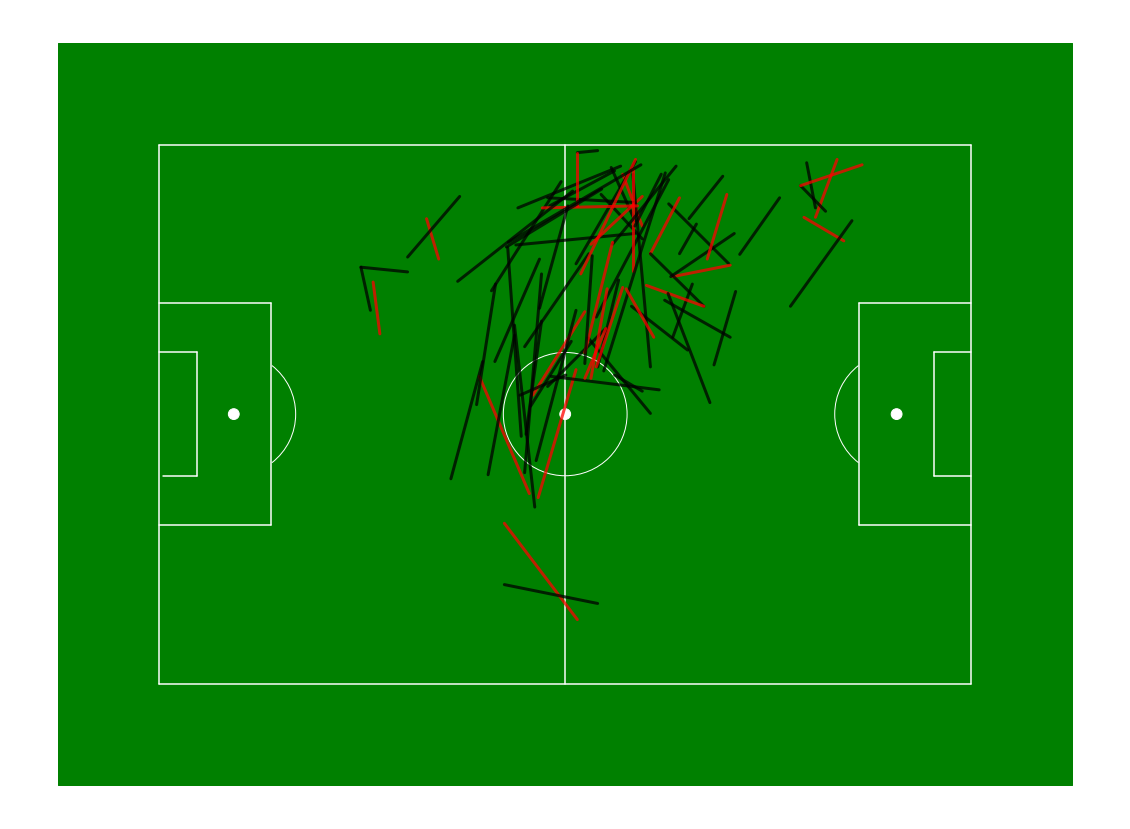

In [60]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    if pass_.pass_recipient_name == "Marco Verratti":
        color = 'red' 
    else:
        color = 'black'
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color= color)
    #plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig('cluster4_passes_to_verratti.png')

In [61]:
#cluster2 = ipasses[(ipasses['cluster'] == 2) & (ipasses['play_pattern_name'] == 'Regular Play')]
cluster2 = ipasses[(ipasses['cluster'] == 2)]
color_labels = cluster2.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

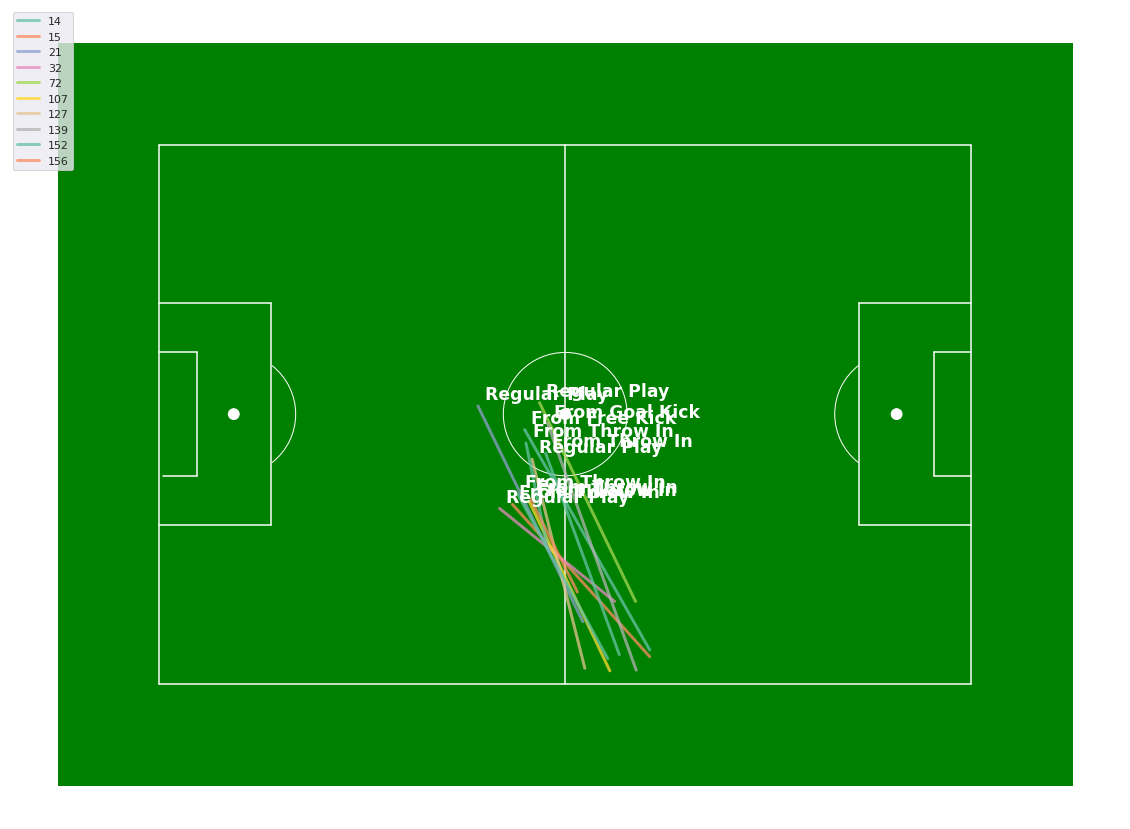

In [62]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster2.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    #plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x+1),y+1,pass_.play_pattern_name, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster2_poss_group.png')

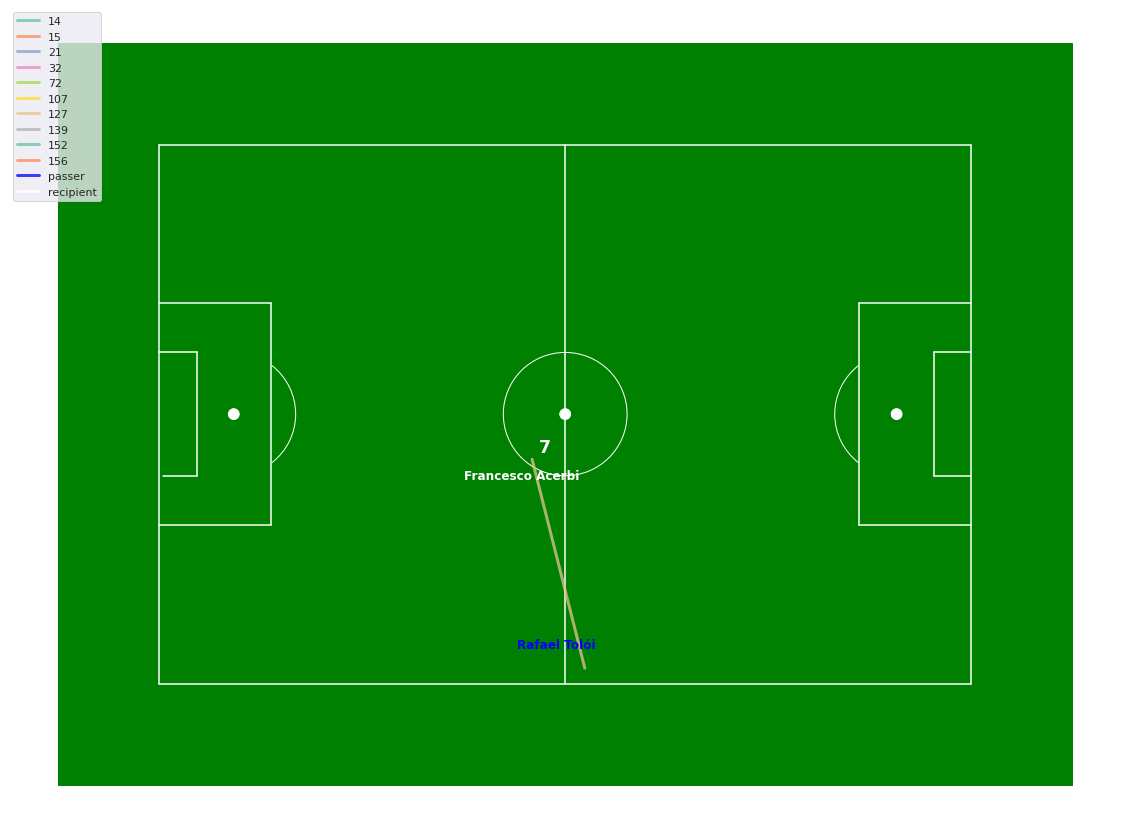

In [63]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster2.iterrows():
    if (index < 0) or (pass_.possession != 127):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster2_127.png')

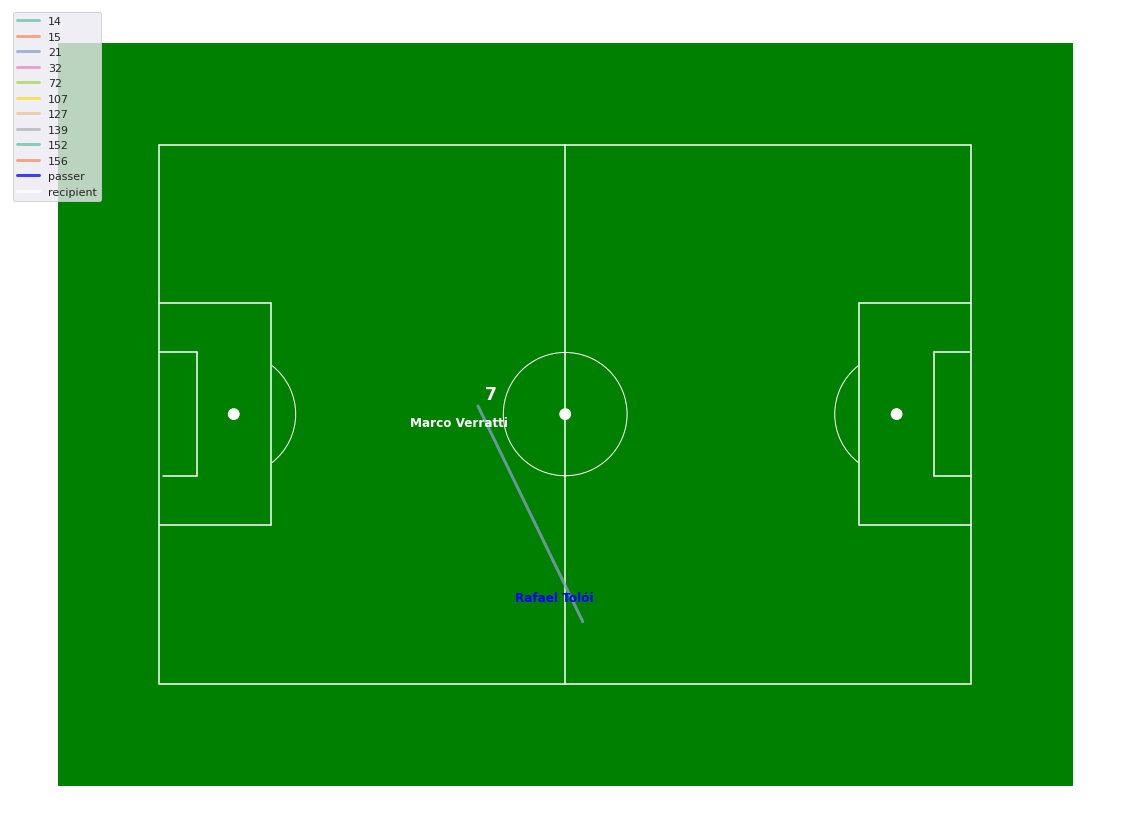

In [64]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster2.iterrows():
    if (index < 0) or (pass_.possession != 21):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster2_21.png')

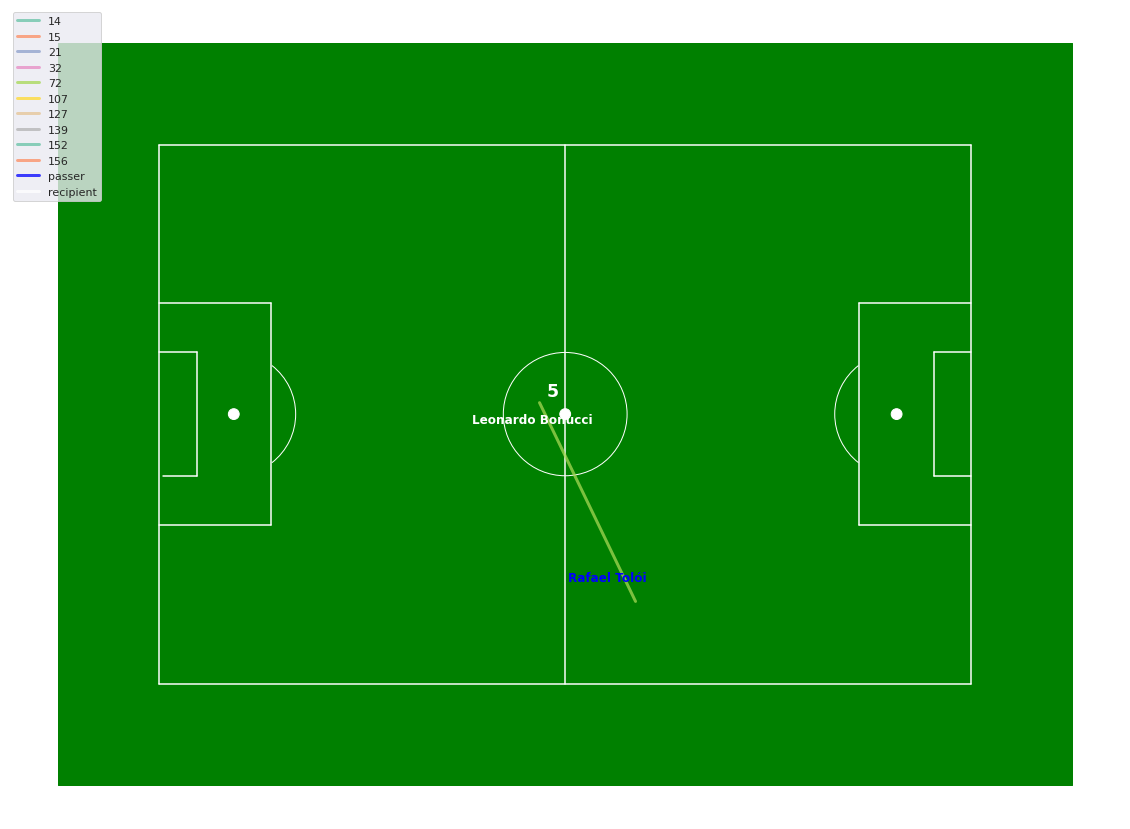

In [65]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster2.iterrows():
    if (index < 0) or (pass_.possession != 72):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster2_72.png')

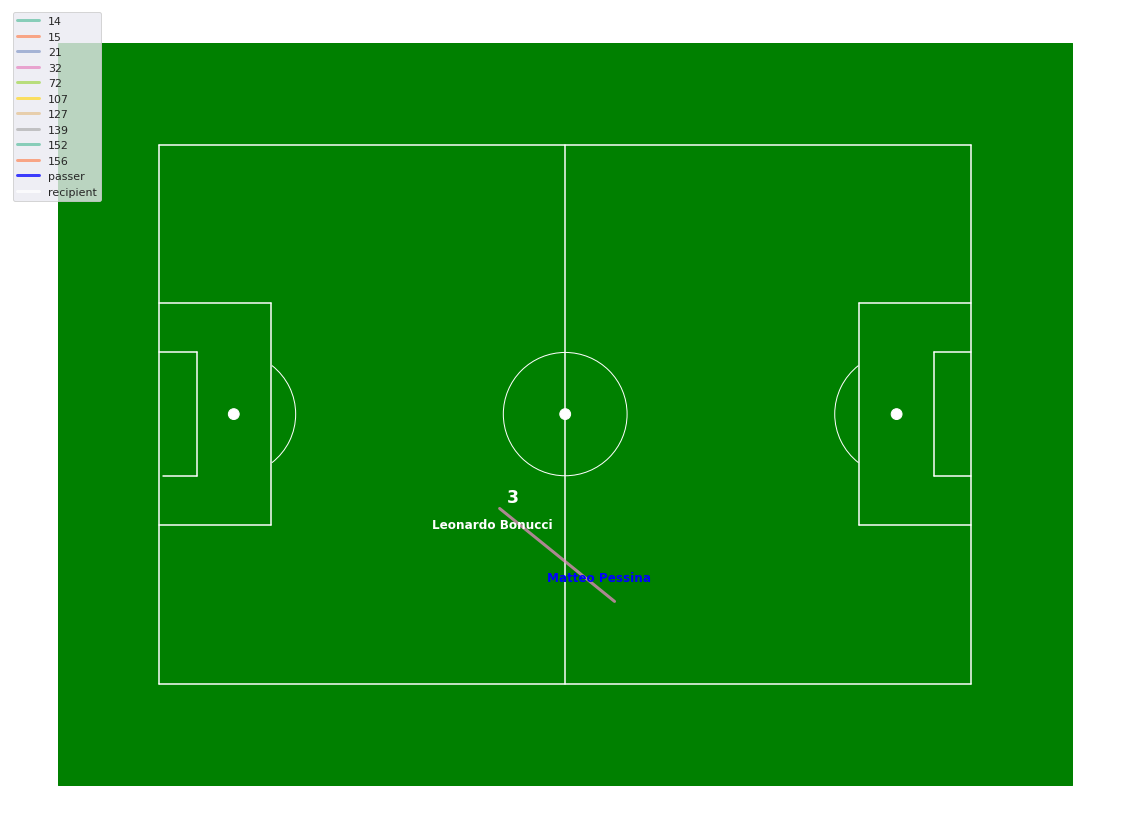

In [66]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster2.iterrows():
    if (index < 0) or (pass_.possession !=32):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-10),y-3,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x-10),end_y+3,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster2_32.png')

In [67]:
cluster2

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count,cluster,gmm_cluster
257,1,6,18,6,18,NaN,NaN,From Free Kick,14,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,5,2,11
289,1,7,13,7,13,NaN,NaN,From Throw In,15,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,5,2,11
419,1,10,33,10,33,NaN,NaN,Regular Play,21,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,7,2,11
619,1,15,45,15,45,NaN,NaN,Regular Play,32,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,3,2,11
1198,1,30,42,30,42,NaN,NaN,Regular Play,72,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,5,2,11
1957,2,7,53,52,53,NaN,NaN,From Throw In,107,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,3,2,11
2345,2,21,20,66,20,NaN,NaN,Regular Play,127,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,7,2,11
2575,2,30,54,75,54,NaN,NaN,From Goal Kick,139,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,12,2,11
2864,2,41,53,86,53,NaN,NaN,From Throw In,152,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,3,2,11
2884,2,42,12,87,12,NaN,NaN,From Throw In,152,Italy,...,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,10,2,0


In [68]:
passy_play = passy
ipasses_play = passy_play[passy['possession_team_name'] == 'Italy']
wpasses_play = passy_play[passy['possession_team_name'] == 'Wales']
dbs = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 3, metric = 'l2')
dbs.fit(ipasses_play[cluster_cols])
ipasses_play['clusters'] = dbs.labels_
bgm2 = BayesianGaussianMixture(n_components=20,
                              random_state=42,
                              max_iter = 1000,
                              init_params = 'kmeans').fit(ipasses_play[cluster_cols])
ipasses_play['gmm_cluster'] = bgm2.predict(ipasses_play[cluster_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [69]:
dbs.labels_

array([ 3, -1,  3, -1, -1, -1, -1, -1, -1,  3, -1, -1,  3, -1, -1,  3, -1,
        3,  3, -1,  3,  3,  3,  3,  3,  3, -1, -1,  3,  3, -1,  0,  1,  2,
       -1, -1, -1, -1, -1, -1, -1,  3,  3,  3,  3,  3, -1,  3,  3, -1, -1,
       -1, -1,  3,  3, -1, -1,  2,  2,  3, -1, -1, -1, -1,  3,  3, -1, -1,
       -1,  3, -1, -1,  2, -1, -1,  3,  3,  3,  3,  3,  1, -1,  3,  3,  3,
       -1,  3,  3,  3,  3, -1, -1,  1,  1,  1, -1, -1, -1,  3,  3,  3,  3,
        3,  3,  3, -1, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1,  2,  2,
       -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1,  3, -1, -1, -1,  1, -1,
       -1,  3,  3,  3,  3,  3,  3, -1,  3, -1, -1, -1, -1,  3,  3, -1, -1,
       -1,  3, -1, -1, -1, -1, -1,  0,  1, -1,  0,  0, -1, -1,  0, -1, -1,
       -1,  3, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1,  0,
       -1, -1, -1, -1,  3, -1,  3,  3,  3,  3, -1,  3, -1,  3,  3,  3, -1,
        3,  3,  2,  2, -1, -1, -1, -1, -1,  0, -1, -1,  3,  3,  3,  3, -1,
       -1, -1, -1,  3,  1

In [70]:
clusters_italy2_play = ipasses.groupby('gmm_cluster').mean()[cluster_cols]

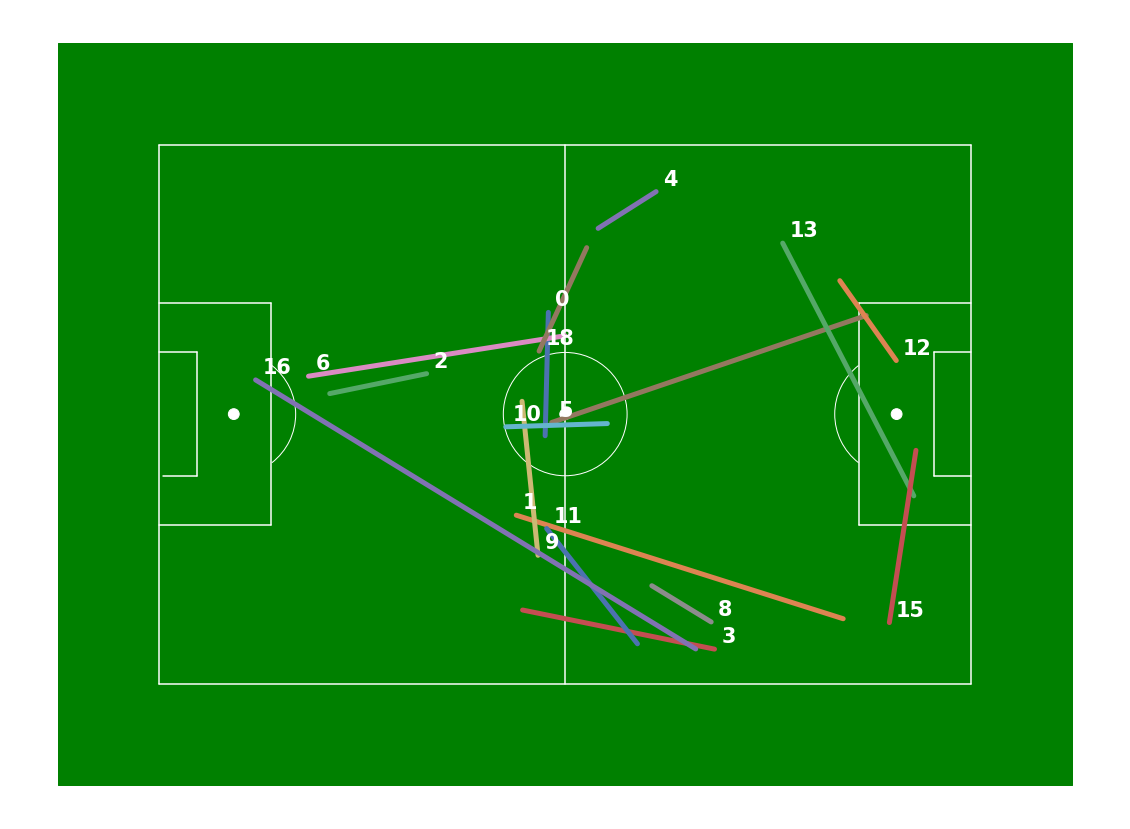

In [71]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_italy2_play.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 5)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig('gmm_cluster2.png')

In [72]:
ipasses_play.gmm_cluster.value_counts()

0     131
18    101
4      82
11     74
9      65
8      60
10     56
5      14
15     14
2      13
13      7
3       4
16      4
6       4
1       3
12      2
Name: gmm_cluster, dtype: int64

In [73]:
cluster4 = ipasses_play[ipasses_play.gmm_cluster == 4]
color_labels = cluster4.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

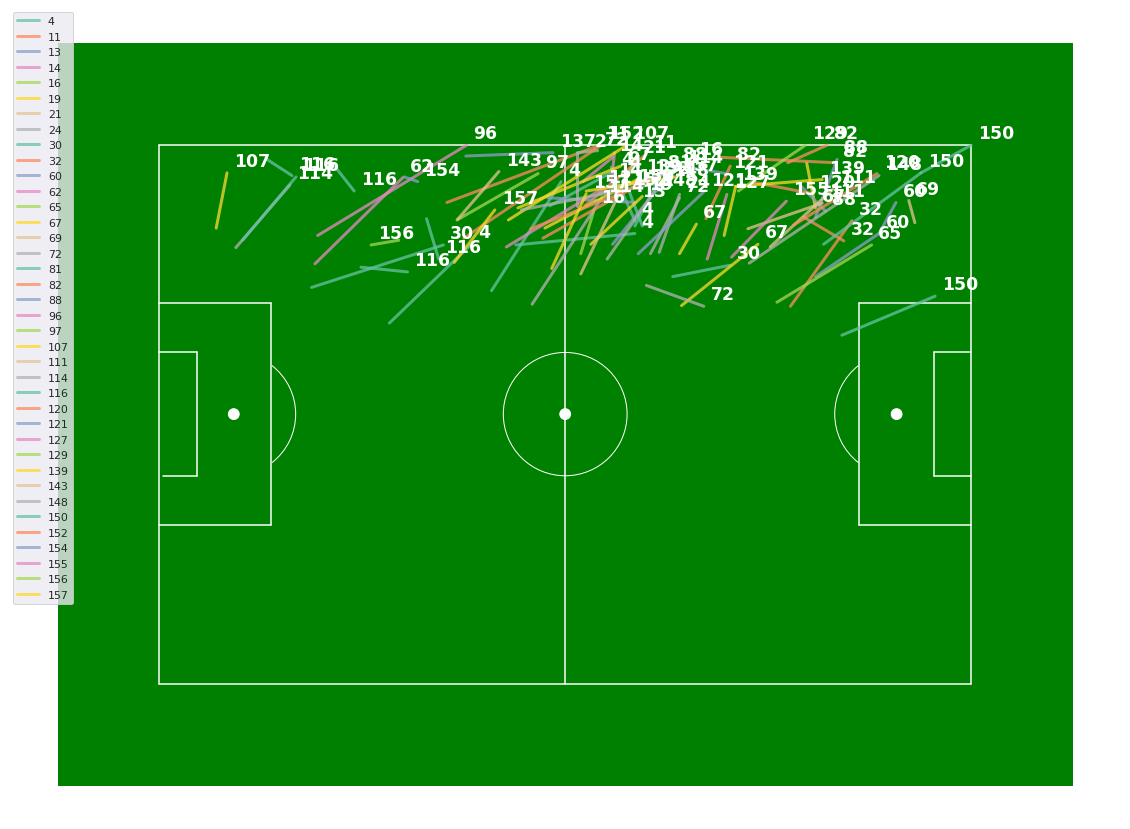

In [74]:

fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster4.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_gmm_play.png')

In [75]:
cluster4.possession.value_counts()

4      6
116    5
67     4
150    4
72     4
152    3
148    3
139    3
114    3
88     3
82     3
157    3
120    2
14     2
127    2
60     2
121    2
32     2
30     2
11     2
16     2
107    2
111    2
13     2
154    1
19     1
155    1
156    1
143    1
65     1
129    1
62     1
21     1
24     1
97     1
81     1
69     1
96     1
Name: possession, dtype: int64

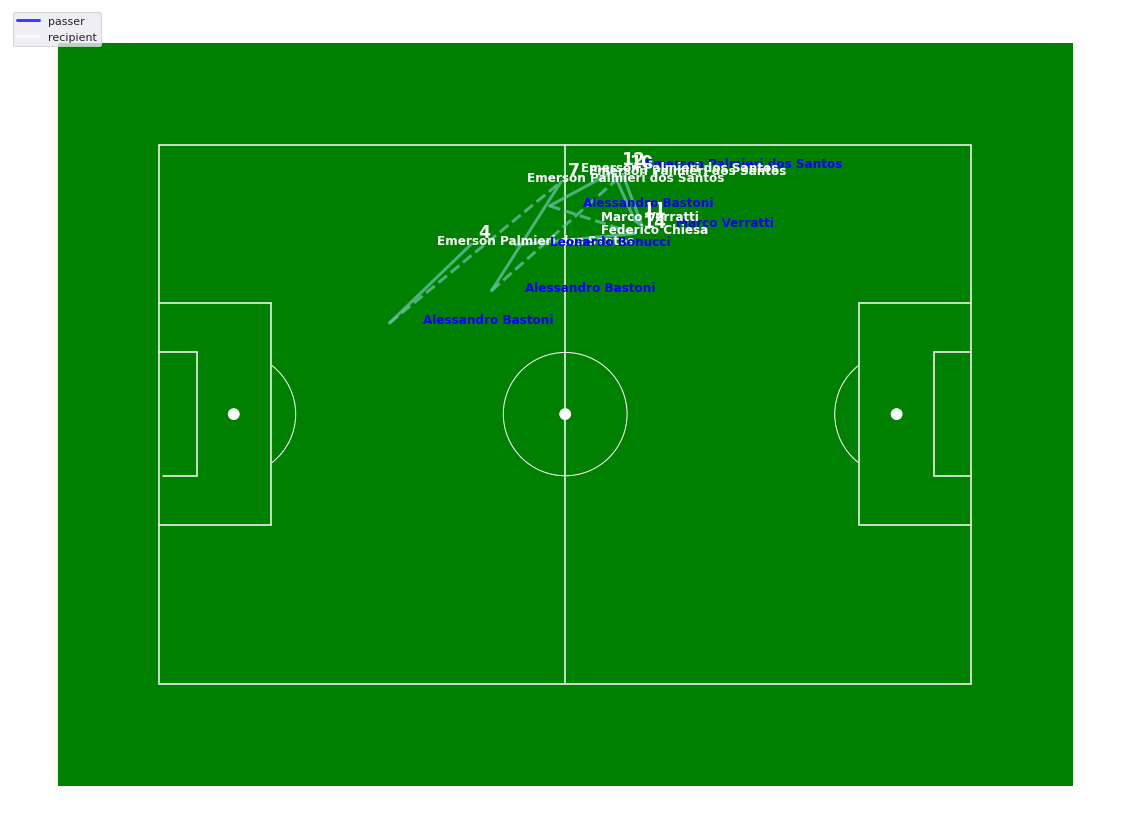

In [76]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster4.iterrows():
    if (index < 0) or (pass_.possession != 4):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster4_4gmm.png')

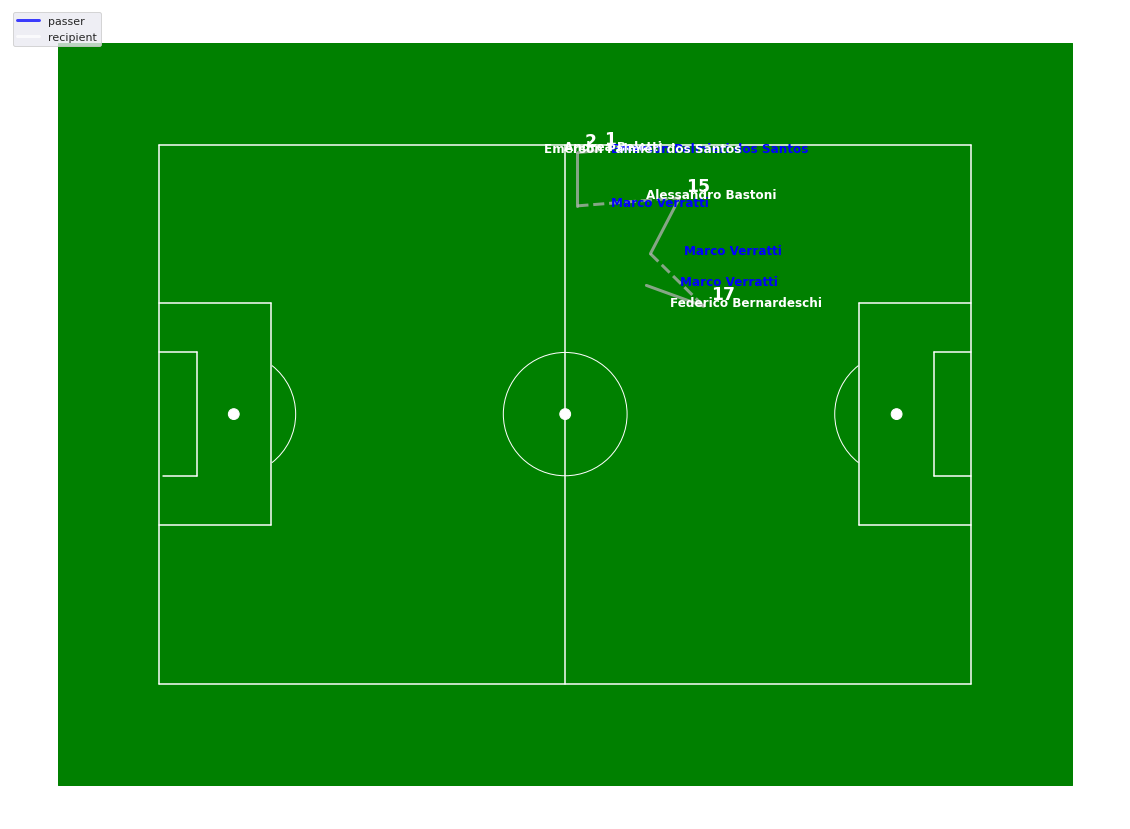

In [77]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster4.iterrows():
    if (index < 0) or (pass_.possession != 72):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_72gmm.png')

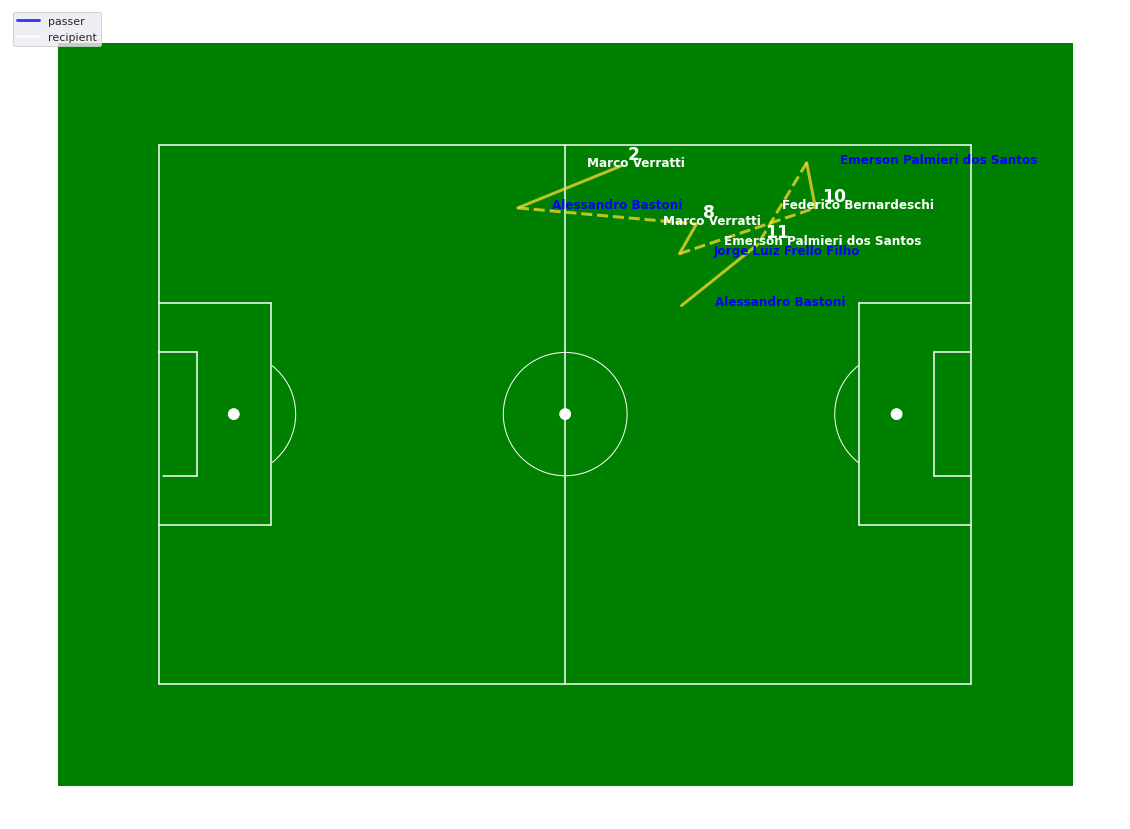

In [78]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster4.iterrows():
    if (index < 0) or (pass_.possession != 67):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_67gmm.png')

In [79]:
cluster0 = ipasses_play[ipasses_play.gmm_cluster == 0]
color_labels = cluster0.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

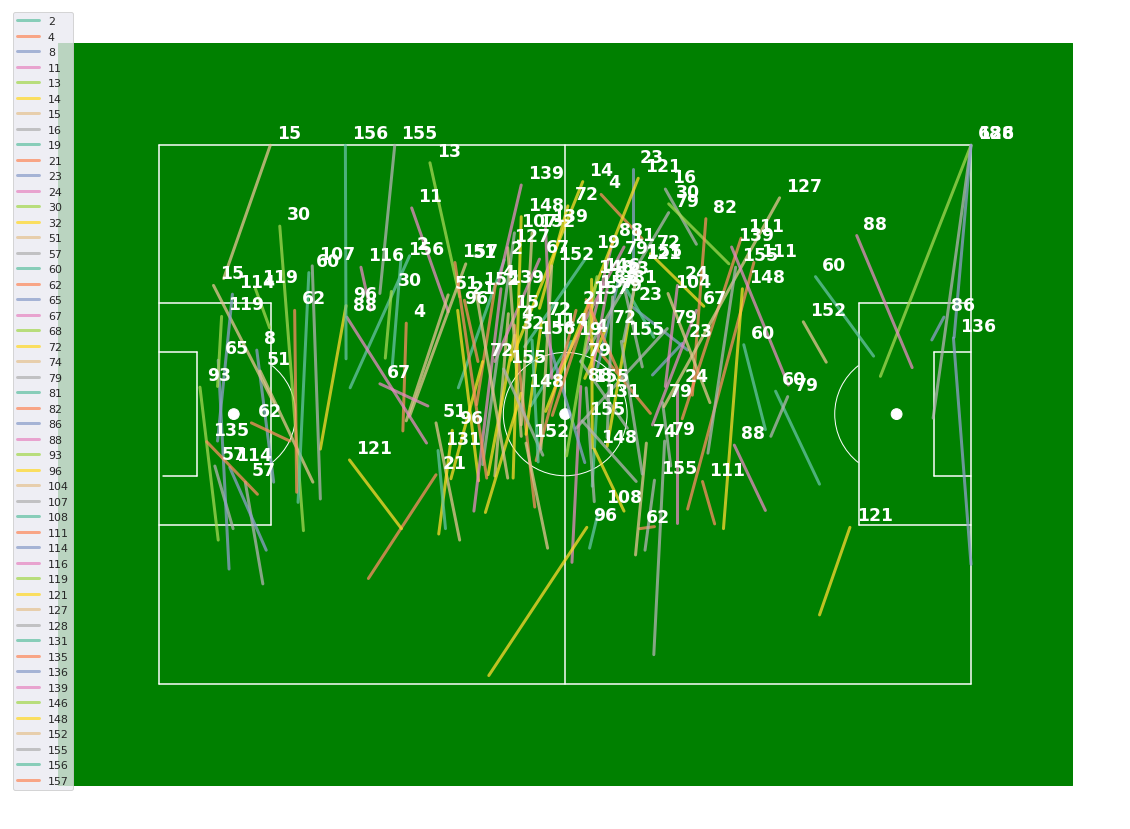

In [80]:

fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster0.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster0_gmm_play.png')

In [81]:
cluster4.possession.value_counts()

4      6
116    5
67     4
150    4
72     4
152    3
148    3
139    3
114    3
88     3
82     3
157    3
120    2
14     2
127    2
60     2
121    2
32     2
30     2
11     2
16     2
107    2
111    2
13     2
154    1
19     1
155    1
156    1
143    1
65     1
129    1
62     1
21     1
24     1
97     1
81     1
69     1
96     1
Name: possession, dtype: int64

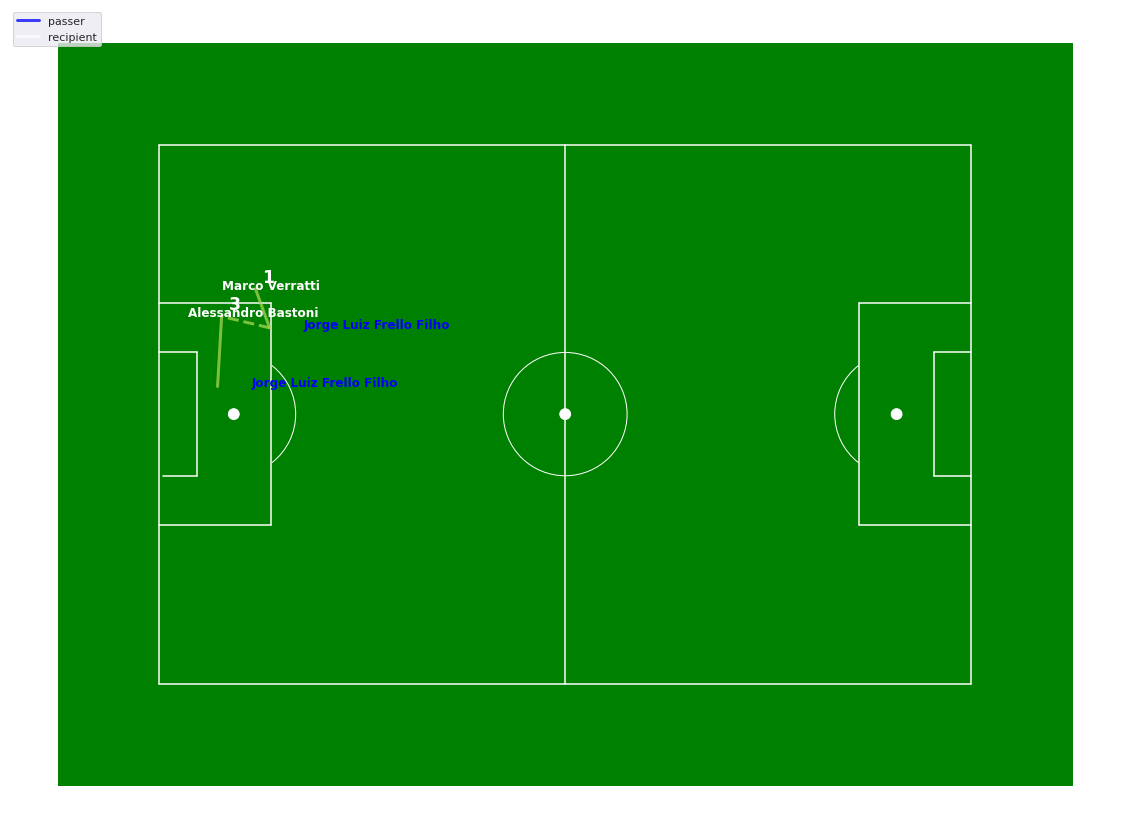

In [82]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster0.iterrows():
    if (index < 0) or (pass_.possession != 119):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster4_119gmm.png')

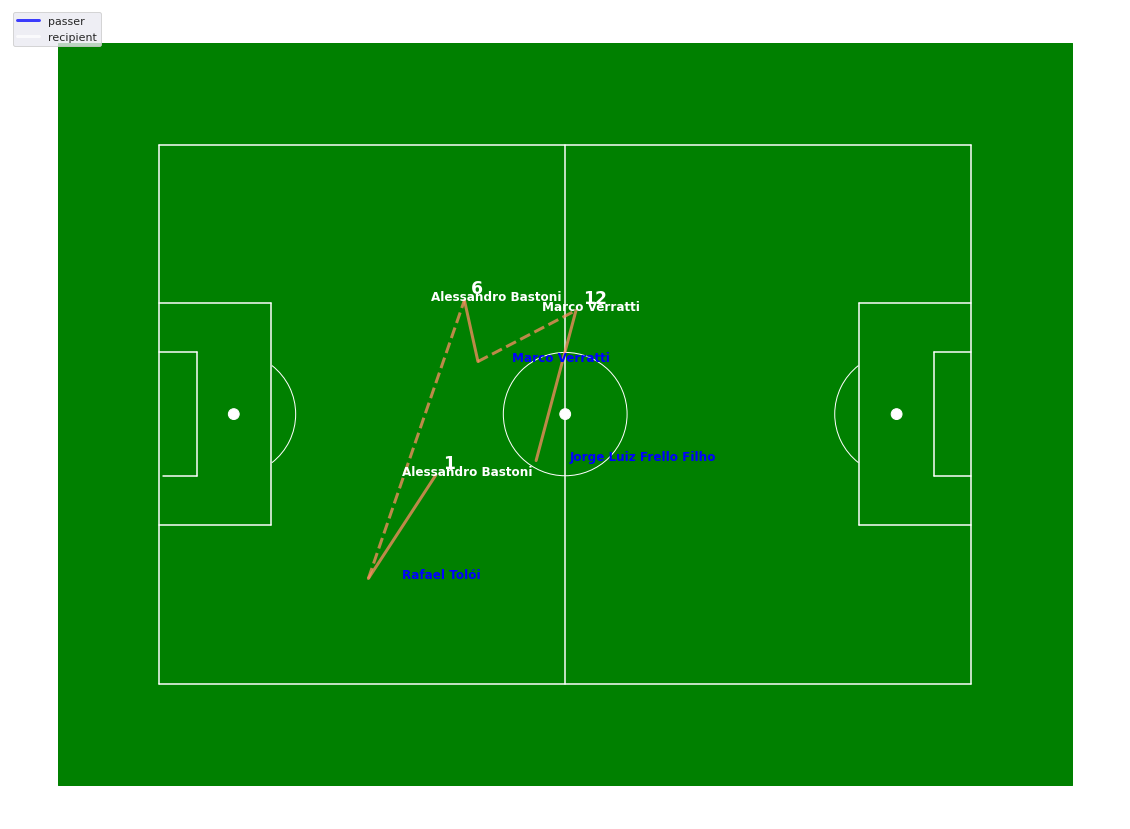

In [83]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster0.iterrows():
    if (index < 0) or (pass_.possession != 21):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('cluster4_21gmm.png')

In [84]:
clusters_italy2_play12 = ipasses_play.groupby('gmm_cluster').mean()[cluster_cols]

In [85]:
clusters_italy2_play12['size'] = ipasses_play.groupby('gmm_cluster').size()

In [86]:
clusters_italy2_play12

,x,y,end_x,end_y,pass_length,size
gmm_cluster,,,,,,
0,57.509160,24.906107,57.035115,43.212214,19.308256,131
1,52.766667,55.000000,101.100000,70.366667,51.801243,3
2,39.507692,34.000000,25.184615,36.953846,16.608426,13
3,82.075000,74.875000,53.700000,69.075000,29.324159,4
4,73.440244,6.984146,64.868293,12.436585,11.806484,82
5,58.000000,41.242857,104.514286,25.371429,51.785486,14
6,22.050000,34.375000,59.975000,28.375000,40.060127,4
8,81.583333,70.843333,72.808333,65.466667,12.266829,60
9,55.981538,60.955385,53.618462,38.101538,24.409347,65


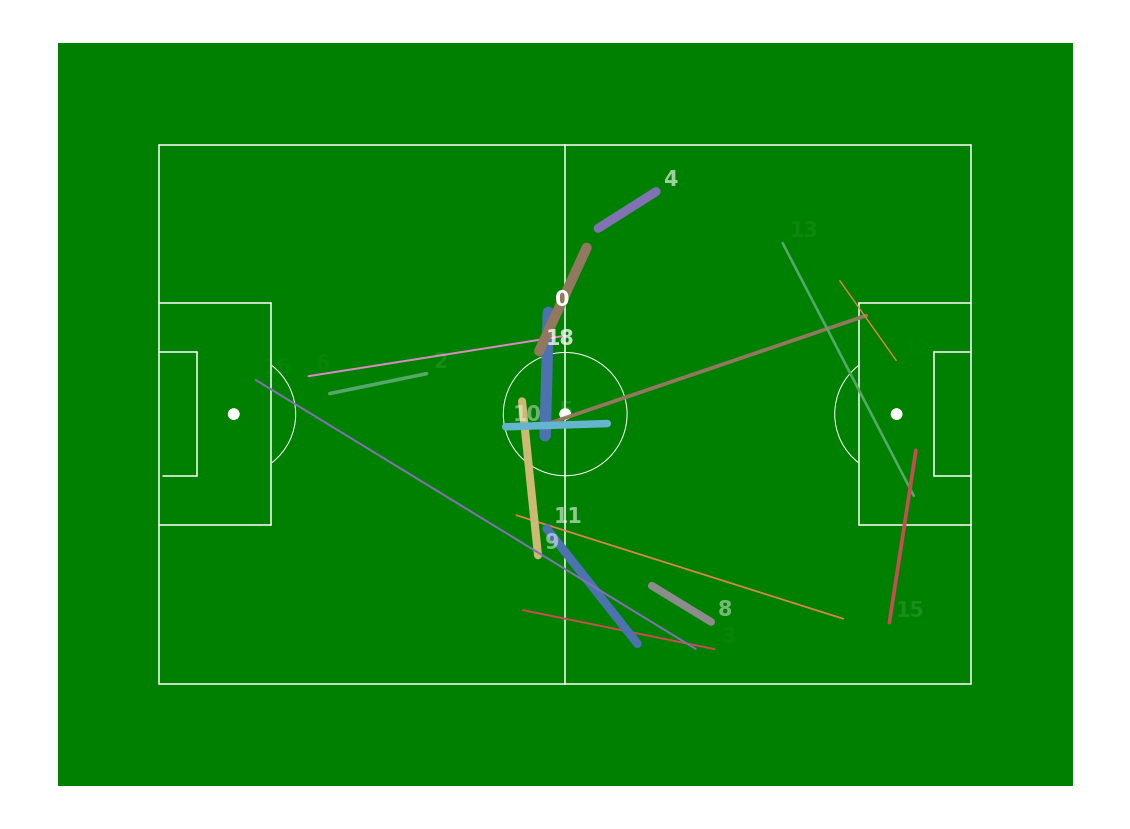

In [87]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_italy2_play12.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    lwidth = np.sqrt(pass_['size'])
    plt.plot([x, end_x], [y, end_y], linewidth = lwidth)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large', alpha = pass_['size'] / clusters_italy2_play12['size'].max())
    plt.savefig('gmm_cluster_size.png')

## Looks like Cluster 15 is an attacking cluster

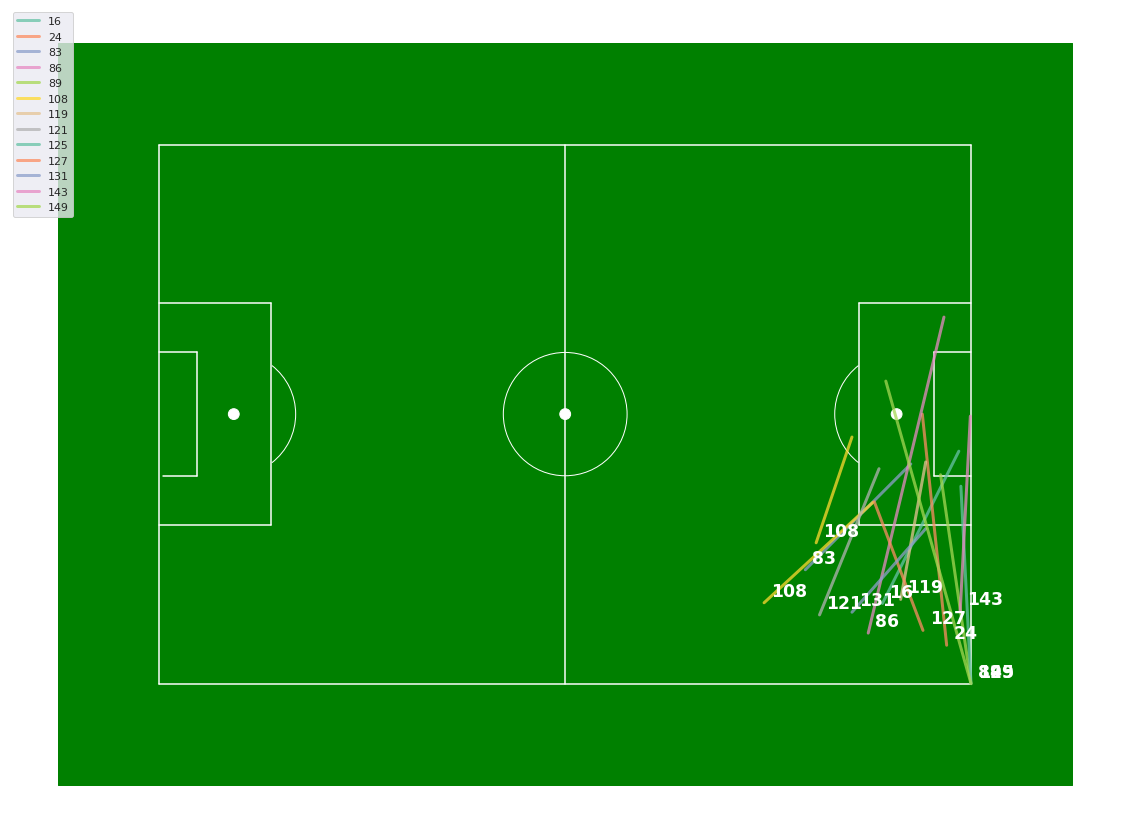

In [88]:
cluster15 = ipasses_play[ipasses_play.gmm_cluster == 15]
color_labels = cluster15.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster15.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster15.png')

In [89]:
cluster15.possession.value_counts()

108    2
16     1
24     1
83     1
86     1
89     1
119    1
121    1
125    1
127    1
131    1
143    1
149    1
Name: possession, dtype: int64

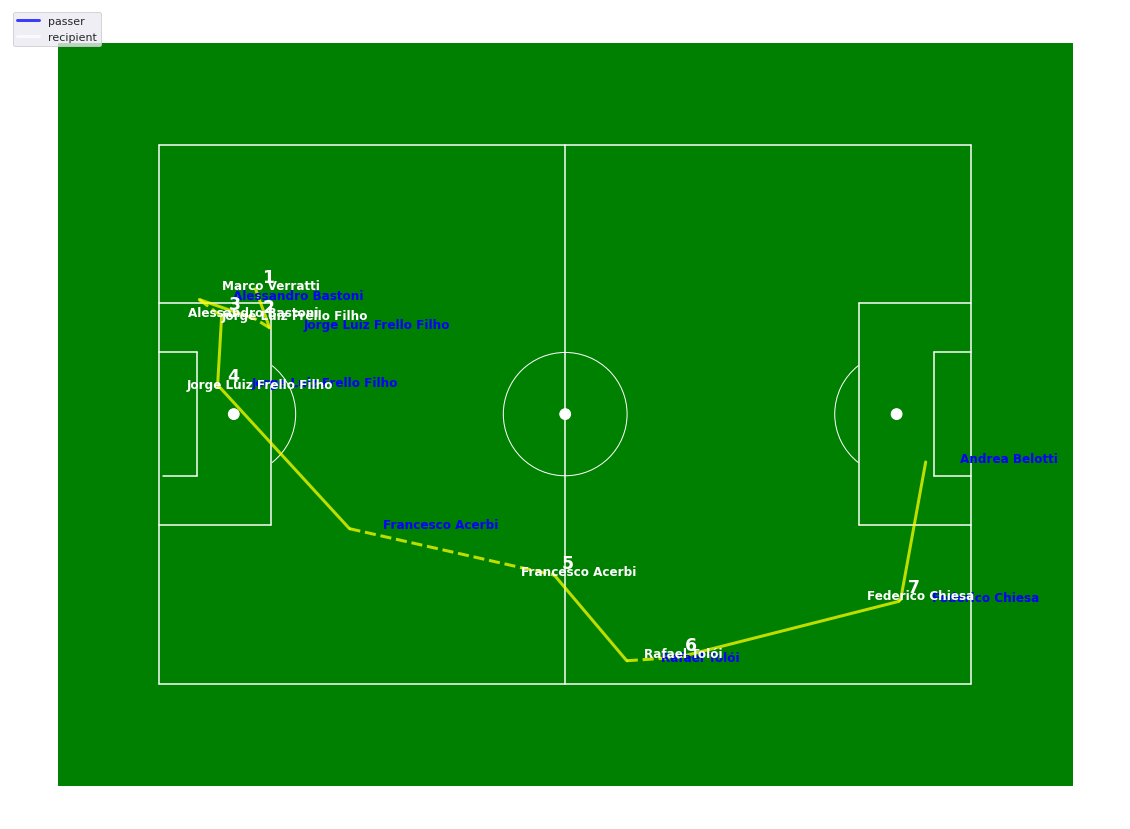

In [90]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in passy.iterrows():
    if (index < 0) or (pass_.possession != 119):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = 'yellow'
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('199_chain.png')

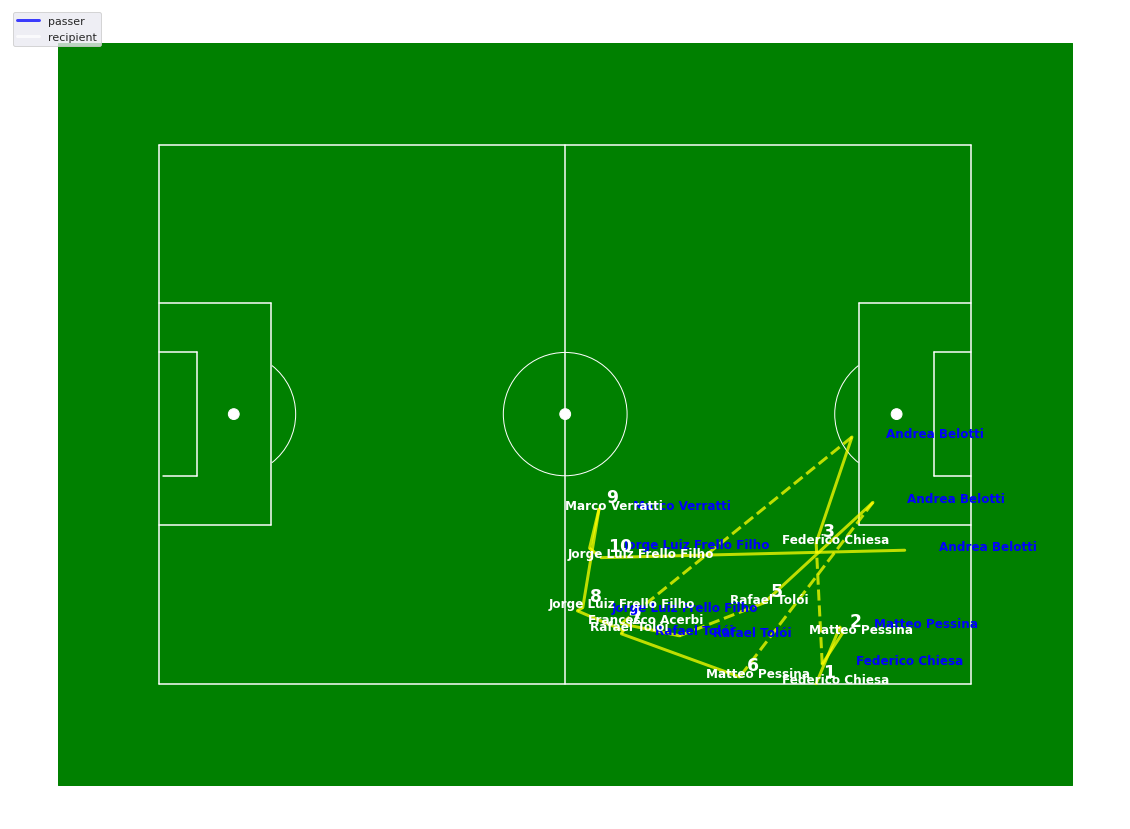

In [91]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in passy.iterrows():
    if (index < 0) or (pass_.possession != 108):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = 'yellow'
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('108_chain.png')

In [92]:
cols = ['id', 'minute', 'second','type_name', 'sub_type_name',
       'outcome_name', 'play_pattern_name',
       'possession', 'possession_team_name',
       'team_name', 'player_name', 'position_name',
       'duration',
       'body_part_name', 'technique_name', 'under_pressure',
       'counterpress', 'out', 'pass_length', 'pass_angle',
        'pass_recipient_name', 'pass_switch', 'pass_cross',
       'pass_shot_assist', 'pass_cut_back',
       'pass_goal_assist', 'ball_recovery_recovery_failure',
       'block_deflection', 'dribble_nutmeg', 'foul_committed_advantage',
       'foul_committed_type_id', 'foul_committed_type_name',
       'foul_committed_card_id', 'foul_committed_card_name',
       'foul_won_advantage', 'foul_won_defensive',
        'shot_statsbomb_xg', 'shot_key_pass_id',
       'shot_first_time', 'shot_redirect', 'shot_deflected',
       'tactics_formation', 'aerial_won']
df_event[df_event.possession == 119][cols].iloc[-5]

id                                de5029d6-e856-45d1-a954-a0a93bf651a7
minute                                                              61
second                                                              32
type_name                                                    Clearance
sub_type_name                                                      NaN
outcome_name                                                       NaN
play_pattern_name                                         Regular Play
possession                                                         119
possession_team_name                                             Italy
team_name                                                        Wales
player_name                                               Chris Gunter
position_name                                         Left Center Back
duration                                                           0.0
body_part_name                                               Left Foot
techni

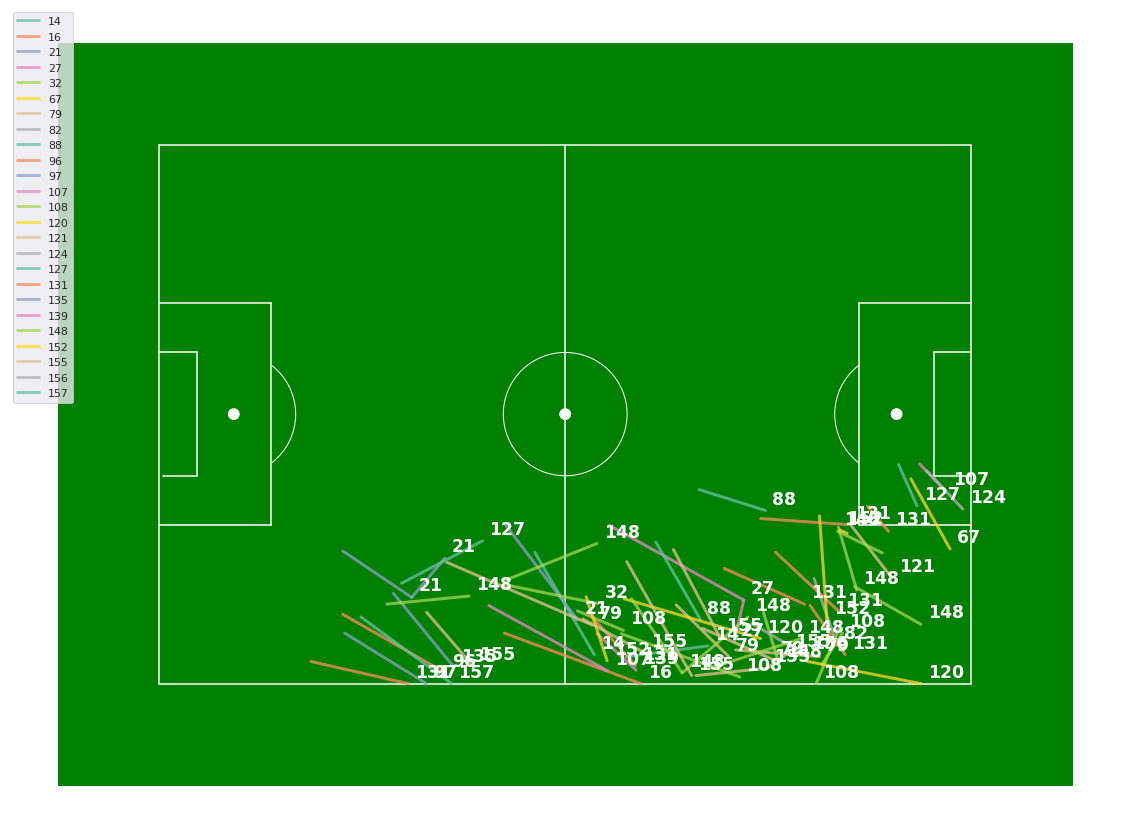

In [93]:
cluster8 = ipasses_play[ipasses_play.gmm_cluster == 8]
color_labels = cluster8.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster8.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster8_gmm_play.png')

In [94]:
cluster8.possession.value_counts()

148    9
131    7
155    6
108    4
79     4
21     3
152    3
107    2
127    2
120    2
14     2
88     2
27     2
97     1
16     1
96     1
121    1
124    1
82     1
135    1
139    1
67     1
32     1
156    1
157    1
Name: possession, dtype: int64

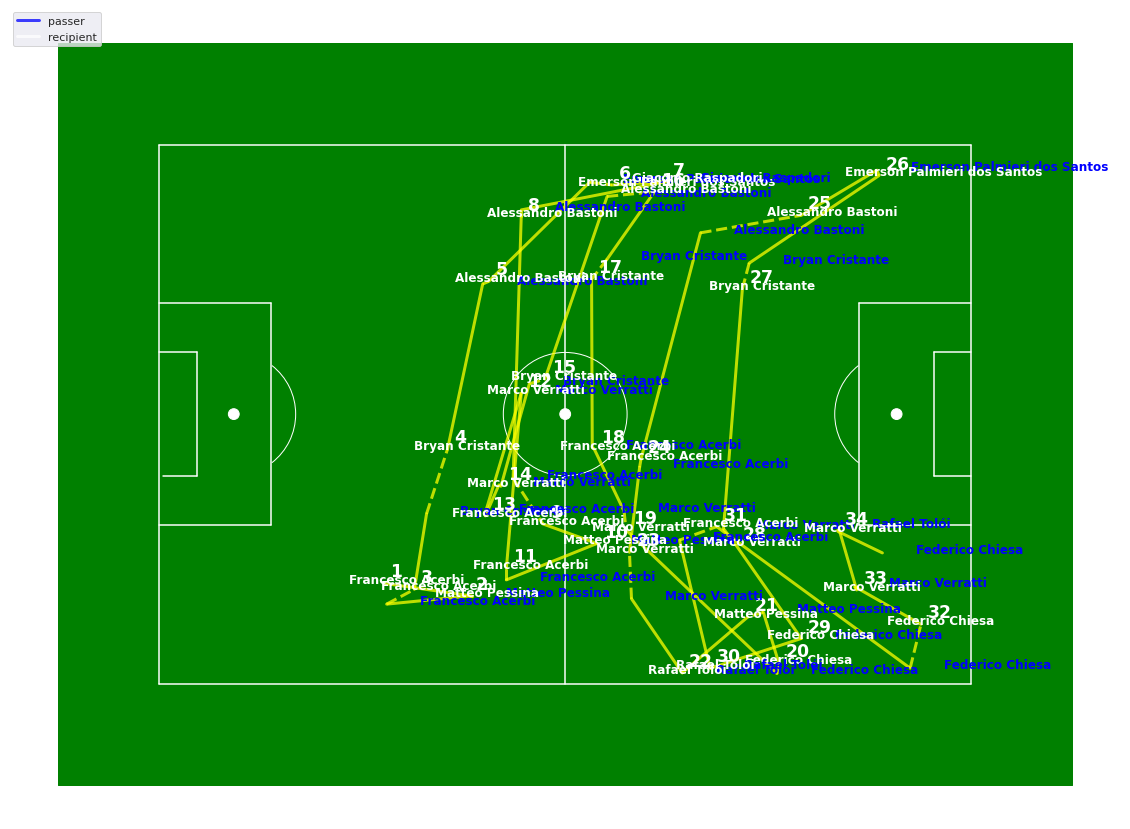

In [95]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in passy.iterrows():
    if (index < 0) or (pass_.possession != 148):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = 'yellow'
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('148_chain.png')

In [96]:
passy.groupby('possession').last()

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession_team_name,team_name,...,pass_angle,pass_recipient_name,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count
possession,,,,,,,,,,,,,,,,,,,,,
2,1,0,38,0,38,Recovery,Pass Offside,From Kick Off,Italy,Italy,...,0.278056,Federico Bernardeschi,High Pass,None,None,None,None,None,True,11
3,1,1,17,1,17,Free Kick,Incomplete,From Free Kick,Wales,Wales,...,0.364044,Gareth Frank Bale,High Pass,None,None,None,None,None,True,1
4,1,2,12,2,12,Recovery,None,Regular Play,Italy,Italy,...,-2.612003,Andrea Belotti,Ground Pass,None,None,None,None,None,False,19
6,1,2,40,2,40,Free Kick,None,From Free Kick,Wales,Wales,...,0.490781,Gareth Frank Bale,Low Pass,None,None,None,None,None,True,5
7,1,3,16,3,16,Free Kick,Incomplete,From Free Kick,Wales,Wales,...,1.590531,Joe Allen,Low Pass,True,True,None,None,None,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2,43,23,88,23,None,Incomplete,From Keeper,Wales,Wales,...,0.256692,Kieffer Roberto Francisco Moore,High Pass,None,None,None,None,None,True,1
154,2,43,32,88,32,None,Incomplete,Regular Play,Italy,Italy,...,-2.804918,Emerson Palmieri dos Santos,Ground Pass,None,None,None,None,None,False,2
155,2,46,5,91,5,Recovery,Out,From Throw In,Italy,Wales,...,0.255567,Bryan Cristante,High Pass,None,None,True,None,None,True,32


In [97]:
match_id = "3788766"
t360 = "../input/socceranalytics/three-sixty/three-sixty"
zipfile = bz2.BZ2File(t360 + f"/{match_id}.json.bz2")
file = zipfile.read()
open(f"{match_id}.json", 'wb').write(file)
with open(f"{match_id}.json") as f:
    events = json.load(f)
    tsdf = pd.json_normalize(events[2:], sep = "_")

In [98]:
tsdf = tsdf.explode("freeze_frame")
freeze_frames = tsdf['freeze_frame'].apply(pd.Series)
tsdf = pd.concat([tsdf, freeze_frames], axis=1)
tsdf = tsdf.drop('freeze_frame', axis=1)

In [99]:
tsdf

,event_uuid,visible_area,teammate,actor,keeper,location
0,48b06034-4334-42a2-883a-621715de0871,"[92.6018757254575, 0.0, 73.8842549225143, 80.0...",True,False,False,"[40.7957, 41.492496]"
0,48b06034-4334-42a2-883a-621715de0871,"[92.6018757254575, 0.0, 73.8842549225143, 80.0...",True,False,False,"[42.298695, 26.311821]"
0,48b06034-4334-42a2-883a-621715de0871,"[92.6018757254575, 0.0, 73.8842549225143, 80.0...",True,False,False,"[42.3674, 63.620655]"
0,48b06034-4334-42a2-883a-621715de0871,"[92.6018757254575, 0.0, 73.8842549225143, 80.0...",True,False,False,"[47.37394, 35.115772]"
0,48b06034-4334-42a2-883a-621715de0871,"[92.6018757254575, 0.0, 73.8842549225143, 80.0...",True,True,False,"[49.106117, 44.205307]"
...,...,...,...,...,...,...
2900,b250030a-49df-44be-aba9-bdd17286cbee,"[43.4881855763658, 80.0, 52.3797128347041, 4.4...",False,False,False,"[73.716965, 38.457947]"
2900,b250030a-49df-44be-aba9-bdd17286cbee,"[43.4881855763658, 80.0, 52.3797128347041, 4.4...",False,False,False,"[74.68676, 56.522327]"
2900,b250030a-49df-44be-aba9-bdd17286cbee,"[43.4881855763658, 80.0, 52.3797128347041, 4.4...",True,False,False,"[80.3996, 53.376534]"
2900,b250030a-49df-44be-aba9-bdd17286cbee,"[43.4881855763658, 80.0, 52.3797128347041, 4.4...",True,False,False,"[82.660416, 43.940613]"


In [100]:
event_mask = tsdf.event_uuid == df_event.id.iloc[115]

In [101]:
tsdf[event_mask]

,event_uuid,visible_area,teammate,actor,keeper,location
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",True,False,False,"[48.02229, 70.071655]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",False,False,False,"[55.818405, 47.315407]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",False,False,False,"[55.88589, 67.598114]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",True,False,False,"[57.97554, 56.521866]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",True,True,False,"[58.399445, 76.30297]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",True,False,False,"[58.687965, 45.88616]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",False,False,False,"[62.77855, 60.81834]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",False,False,False,"[64.21606, 74.94768]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",True,False,False,"[66.44923, 29.370728]"
105,7133c57c-3e5b-421e-9dae-157a8fc5687e,"[41.8544356757662, 80.0, 50.8350651579578, 13....",False,False,False,"[67.01784, 23.95739]"


In [102]:
df_event[(df_event['type_name'] == "Shot") | (df_event['type_name'] == "Clearance")].possession

224      12
446      21
517      24
543      27
648      32
       ... 
2933    152
2939    152
2944    153
3055    155
3089    156
Name: possession, Length: 61, dtype: int64

In [103]:
df_event[(df_event['type_name'] == "Shot")].possession

446      21
543      27
650      32
652      32
958      60
1052     64
1077     65
1154     67
1287     76
1405     81
1433     83
1537     88
1946    105
2044    108
2097    111
2312    124
2317    125
2351    127
2379    127
2541    138
2802    148
2811    149
2921    152
2933    152
2939    152
3055    155
Name: possession, dtype: int64

In [104]:
unique_sc = df_event[(df_event['type_name'] == "Shot") | (df_event['type_name'] == "Clearance")].possession.unique()

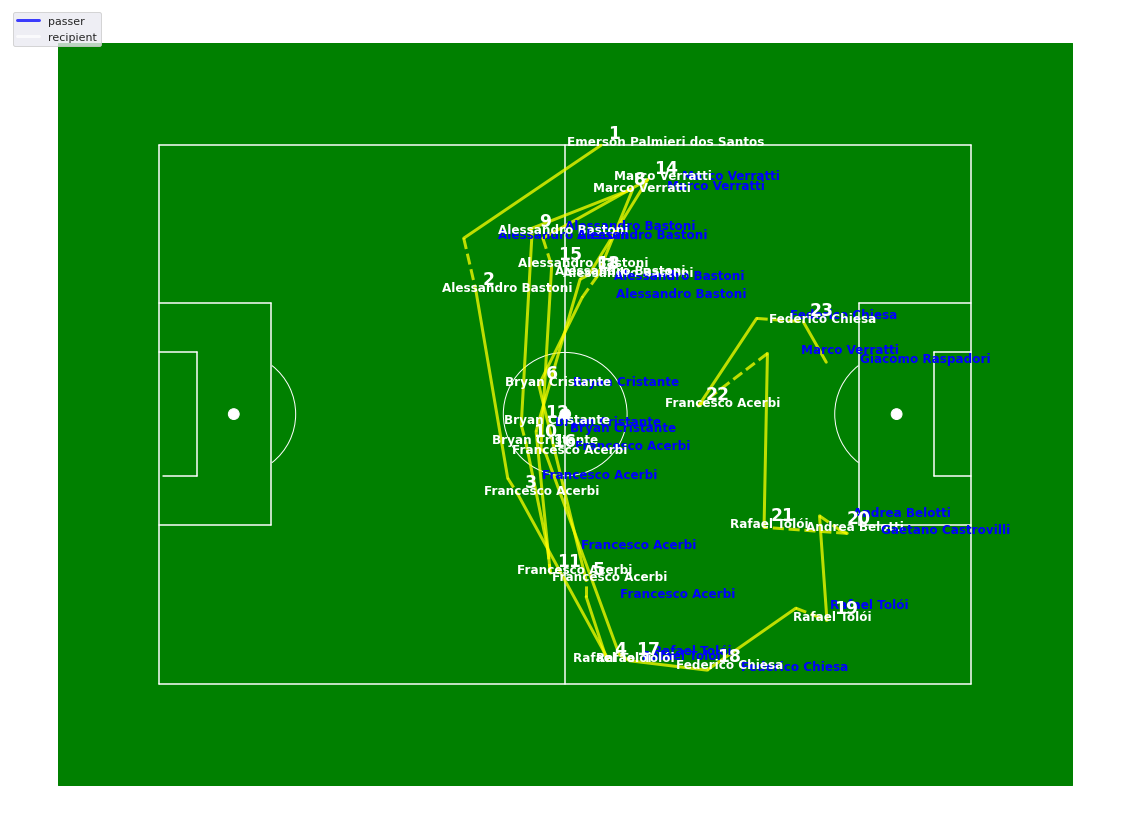

In [105]:
end_x, end_y = -1, -1
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in passy.iterrows():
    if (index < 0) or (pass_.possession != 152):
        continue
    x, y = pass_['x'], pass_['y']
    y = 80 - y
    if (end_x != -1):
        ax.plot([end_x, x], [end_y, y], linewidth = 3, linestyle = 'dashed', alpha = 0.75, color = color)
        
    end_x, end_y = pass_['end_x'], pass_['end_y']
    
    end_y = 80 - end_y
    color = 'yellow'
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.p_count, color = "white", fontweight = 'bold', fontsize = 'x-large')
    plt.text((x-5),y,pass_.player_name, color = "white", fontweight = 'bold', fontsize = 'medium')
    plt.text((end_x+5),end_y,pass_.pass_recipient_name, color = "blue", fontweight = 'bold', fontsize = 'medium')


# for c in color_labels:
#     ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
    
for a, b in zip(['blue', 'white'], ['passer', 'recipient']):
    ax.plot(x, y, linewidth = 3, color = a, alpha = 0.75, label = b)
ax.legend(loc = 'upper left')

plt.savefig('152_chain.png')

In [106]:
passy[passy.possession == 152]

,period,timestamp_minute,timestamp_second,minute,second,sub_type_name,outcome_name,play_pattern_name,possession,possession_team_name,...,pass_angle,pass_recipient_name,pass_height_name,pass_switch,pass_cross,pass_shot_assist,pass_cut_back,pass_goal_assist,direction,p_count
2859,2,41,46,86,46,Throw-in,NaN,From Throw In,152,Italy,...,2.544551,Alessandro Bastoni,Low Pass,NaN,NaN,NaN,NaN,NaN,False,1
2861,2,41,51,86,51,NaN,NaN,From Throw In,152,Italy,...,1.403315,Francesco Acerbi,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,2
2864,2,41,53,86,53,NaN,NaN,From Throw In,152,Italy,...,1.071737,Rafael Tolói,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,3
2867,2,41,56,86,56,NaN,NaN,From Throw In,152,Italy,...,-1.886218,Francesco Acerbi,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,4
2870,2,41,59,86,59,NaN,NaN,From Throw In,152,Italy,...,-1.807645,Bryan Cristante,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,5
2872,2,42,1,87,1,NaN,NaN,From Throw In,152,Italy,...,-1.113321,Alessandro Bastoni,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,6
2875,2,42,3,87,3,NaN,NaN,From Throw In,152,Italy,...,-1.183676,Marco Verratti,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,7
2878,2,42,5,87,5,NaN,NaN,From Throw In,152,Italy,...,2.765952,Alessandro Bastoni,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,8
2881,2,42,9,87,9,NaN,NaN,From Throw In,152,Italy,...,1.626878,Bryan Cristante,Ground Pass,NaN,NaN,NaN,NaN,NaN,False,9
2884,2,42,12,87,12,NaN,NaN,From Throw In,152,Italy,...,1.368475,Francesco Acerbi,Ground Pass,NaN,NaN,NaN,NaN,NaN,True,10


In [107]:
player_clusters = ipasses.groupby(['player_name', 'gmm_cluster']).size().reset_index()
player_clusters.columns = ['player_name', 'cluster', 'ccount']
player_clusters = player_clusters.sort_values(by = ['player_name', 'ccount', 'cluster'], ascending = False)

In [108]:
player_clusters.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


cluster    8.163793
ccount     5.465517
dtype: float64

In [109]:
player_clusters[player_clusters.ccount > 5]

,player_name,cluster,ccount
110,Rafael Tolói,8,22
111,Rafael Tolói,9,15
113,Rafael Tolói,11,12
112,Rafael Tolói,10,10
101,Matteo Pessina,8,11
89,Marco Verratti,0,42
99,Marco Verratti,18,25
91,Marco Verratti,4,13
94,Marco Verratti,9,10
96,Marco Verratti,11,6


<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

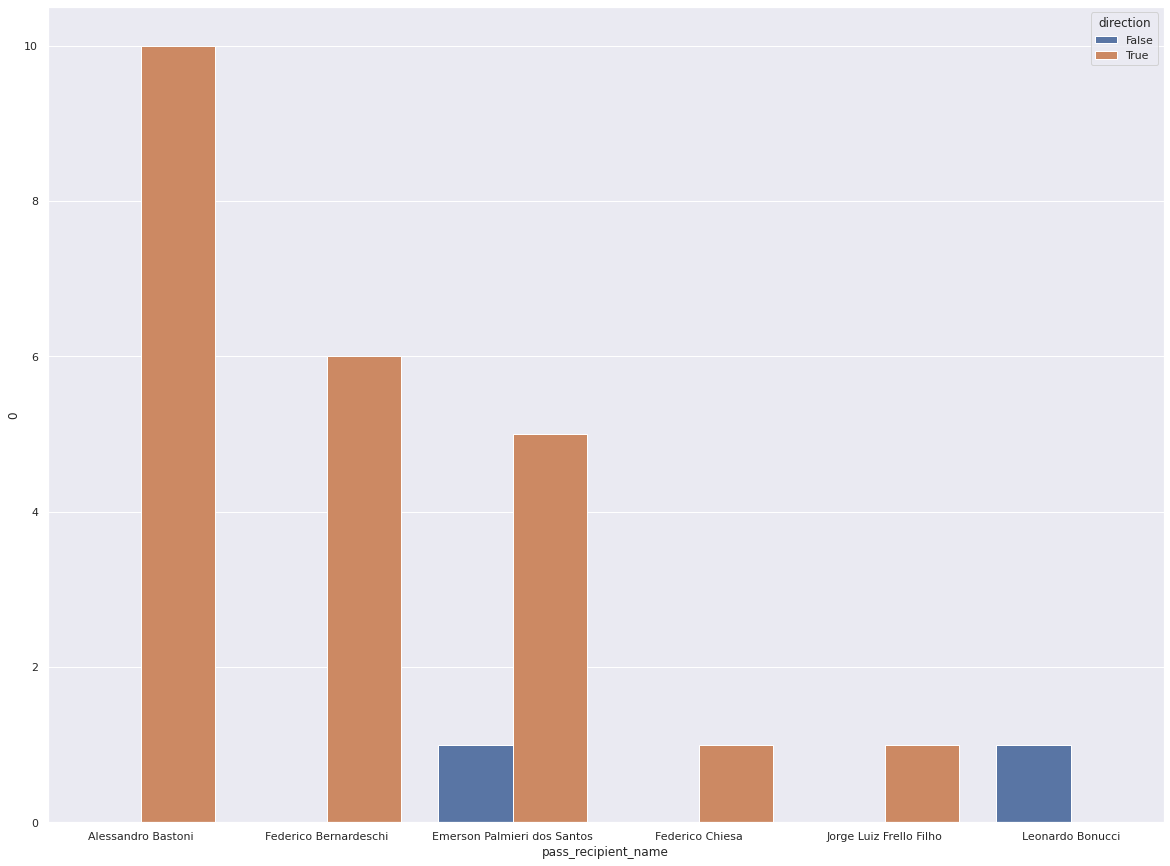

In [110]:
pc = ipasses[(ipasses.player_name == 'Marco Verratti') & (ipasses.gmm_cluster == 18)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

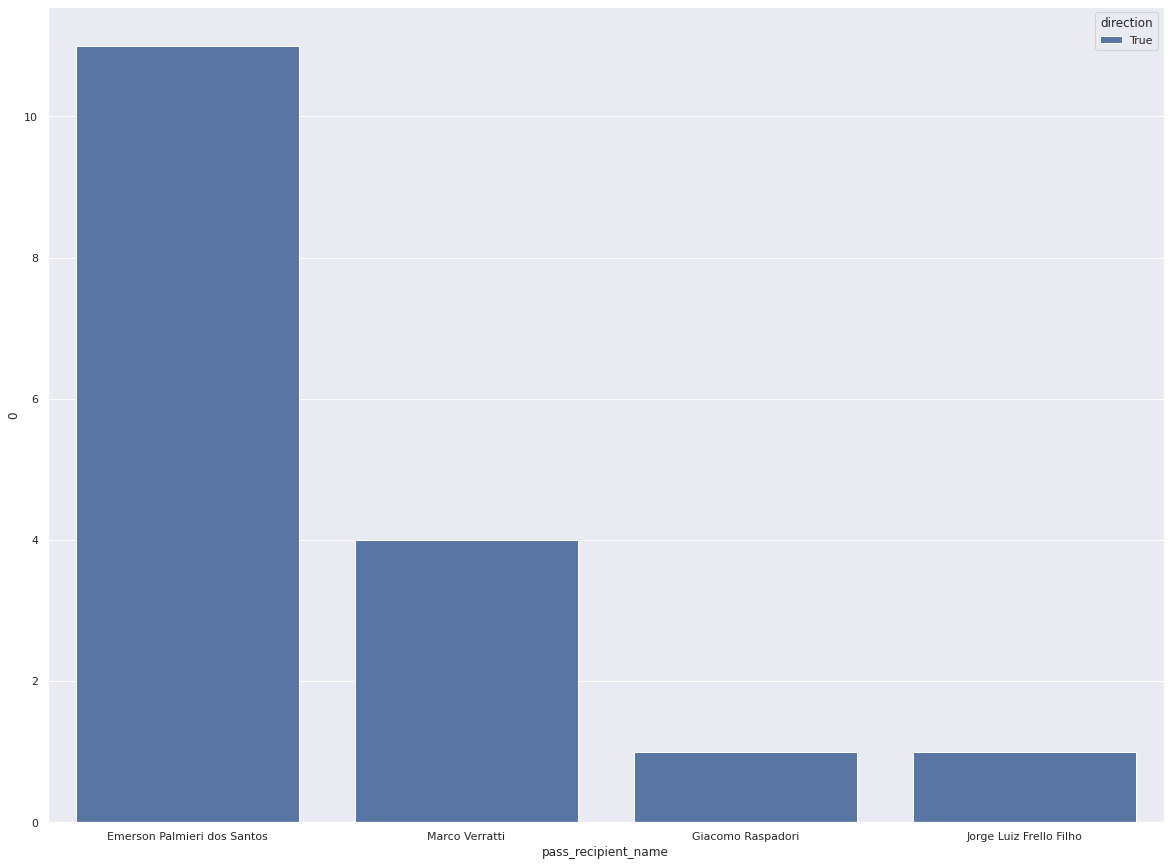

In [111]:
pc = ipasses[(ipasses.player_name == 'Alessandro Bastoni') & (ipasses.gmm_cluster == 18)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

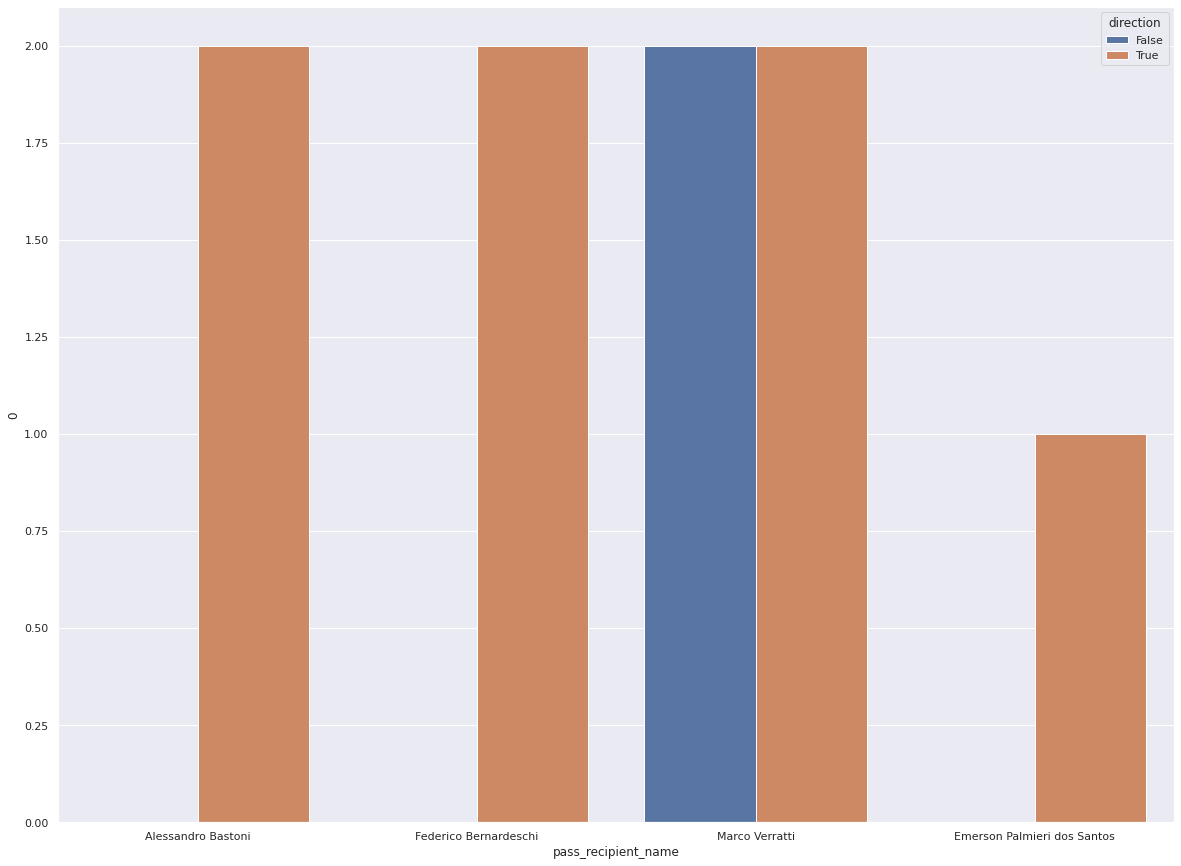

In [112]:
pc = ipasses[(ipasses.player_name == 'Jorge Luiz Frello Filho') & (ipasses.gmm_cluster == 18)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

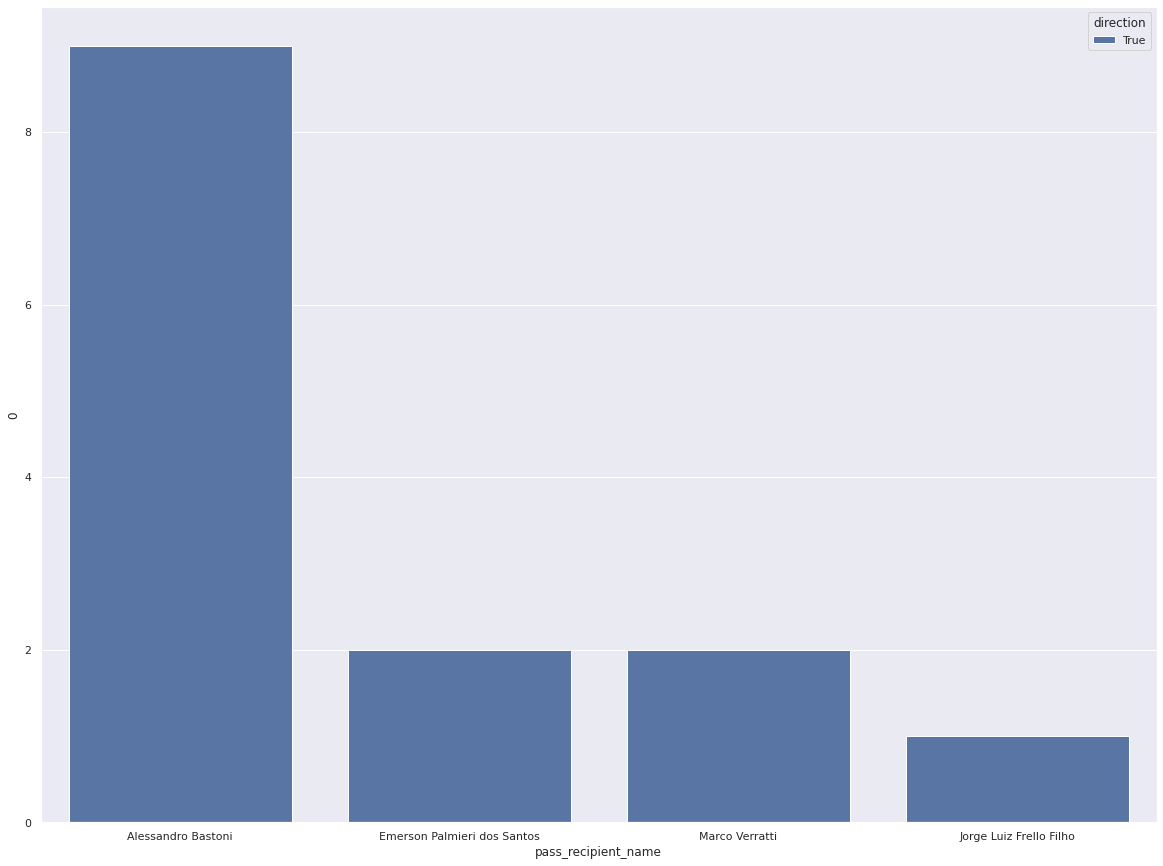

In [113]:
pc = ipasses[(ipasses.player_name == 'Leonardo Bonucci') & (ipasses.gmm_cluster == 18)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

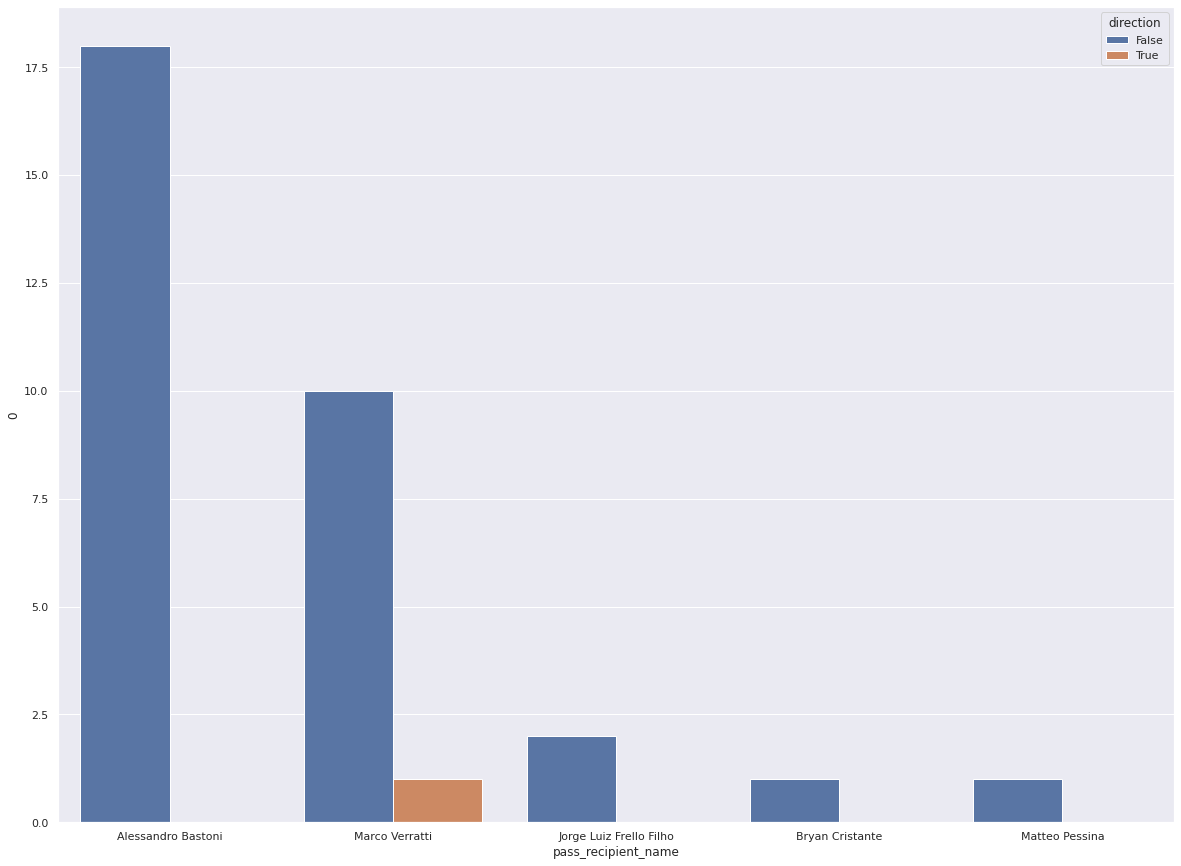

In [114]:
pc = ipasses[(ipasses.player_name == 'Emerson Palmieri dos Santos') & (ipasses.gmm_cluster == 4)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

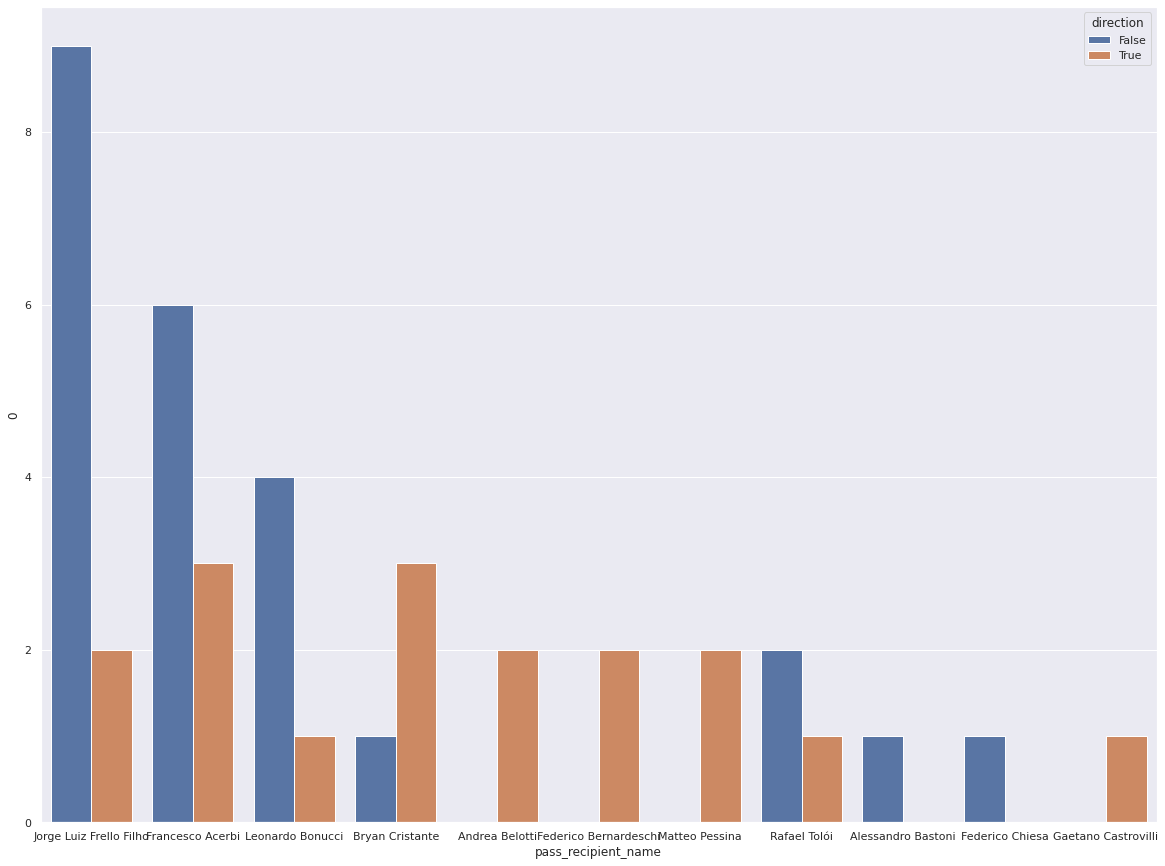

In [115]:
pc = ipasses[(ipasses.player_name == 'Marco Verratti') & (ipasses.gmm_cluster == 0)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

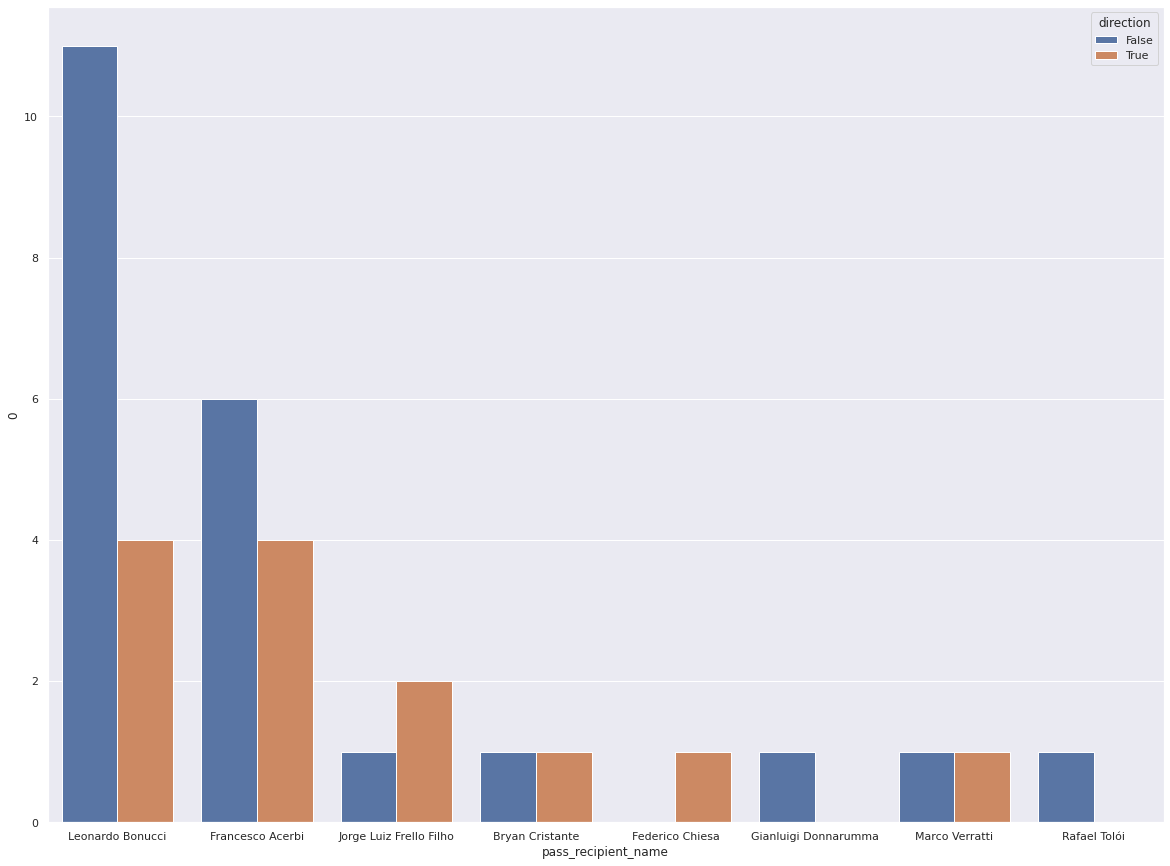

In [116]:
pc = ipasses[(ipasses.player_name == 'Alessandro Bastoni') & (ipasses.gmm_cluster == 0)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

<AxesSubplot:xlabel='pass_recipient_name', ylabel='0'>

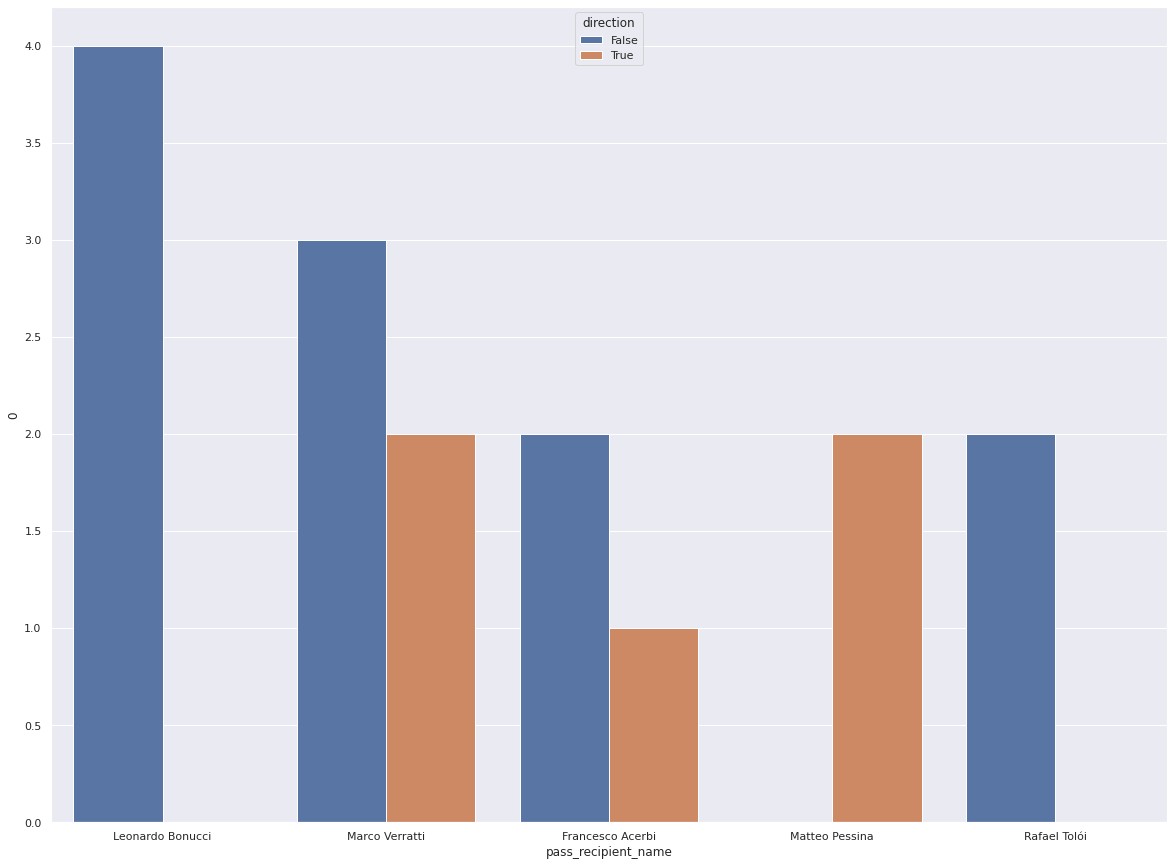

In [117]:
pc = ipasses[(ipasses.player_name == 'Jorge Luiz Frello Filho') & (ipasses.gmm_cluster == 0)][['pass_recipient_name', 'direction']].value_counts().reset_index()
sns.barplot(data = pc, x = 'pass_recipient_name', y = 0, hue = 'direction')

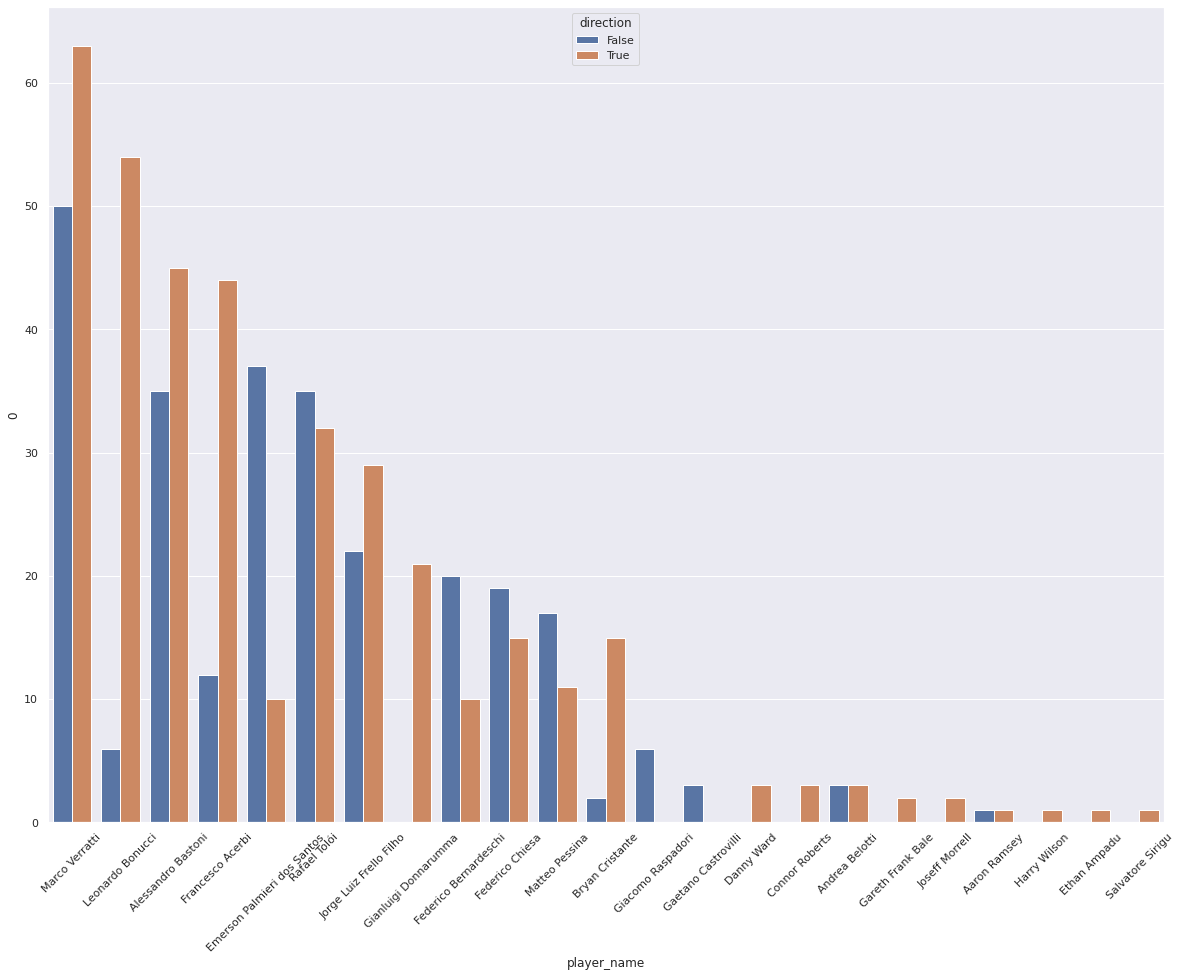

In [118]:
italy_d = ipasses.groupby(['player_name', 'direction']).size().reset_index().sort_values(by=0,  ascending = False)
sns.barplot(data = italy_d, x = 'player_name', y = 0, hue = 'direction')
plt.xticks(rotation=45)
plt.show()

In [119]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 3)
clusterer.fit(wpasses[cluster_cols])
clusterer.labels_

array([-1,  2,  2,  2,  2,  2, -1, -1,  2,  2,  2, -1,  2,  2,  1,  2,  2,
        0,  1,  2,  2,  2,  2,  2, -1, -1,  2,  2,  1, -1,  2,  2,  2,  0,
        1, -1,  2,  1,  2,  2,  2,  1,  2,  2,  2,  0,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
       -1,  2, -1,  2,  0,  2,  2, -1,  2,  0,  1,  2,  2,  1, -1,  2,  2,
        2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2, -1,  2,  2,  2, -1,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2, -1,
       -1,  1,  1,  2,  2,  2,  2,  1, -1,  2,  0,  1,  2,  2,  2, -1,  2,
        2, -1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1,  2,  2,
        2,  2,  2, -1,  2,  2,  2, -1,  2,  2, -1,  2,  2,  2, -1,  2,  2,
        2,  2,  2,  2,  2, -1,  2, -1,  2,  2,  2,  2,  0,  1, -1, -1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  1,  2,  2, -1,  2,
        2,  2, -1,  2,  2,  2,  2, -1, -1,  2,  2,  2,  2,  2,  2, -1,  2,
        2,  2,  2,  0, -1

In [120]:
wpasses['cluster'] = clusterer.labels_
clusters_wales = wpasses.groupby('cluster')[cluster_cols].mean()
clusters_wales['x']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


cluster
-1    58.000000
 0    18.550000
 1     7.632000
 2    51.656983
Name: x, dtype: float64

In [121]:
bgmw = BayesianGaussianMixture(n_components=20,
                              random_state=42,
                              max_iter = 1000,
                              init_params = 'kmeans').fit(wpasses[cluster_cols])
wpasses['gmm_cluster'] = bgm2.predict(wpasses[cluster_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


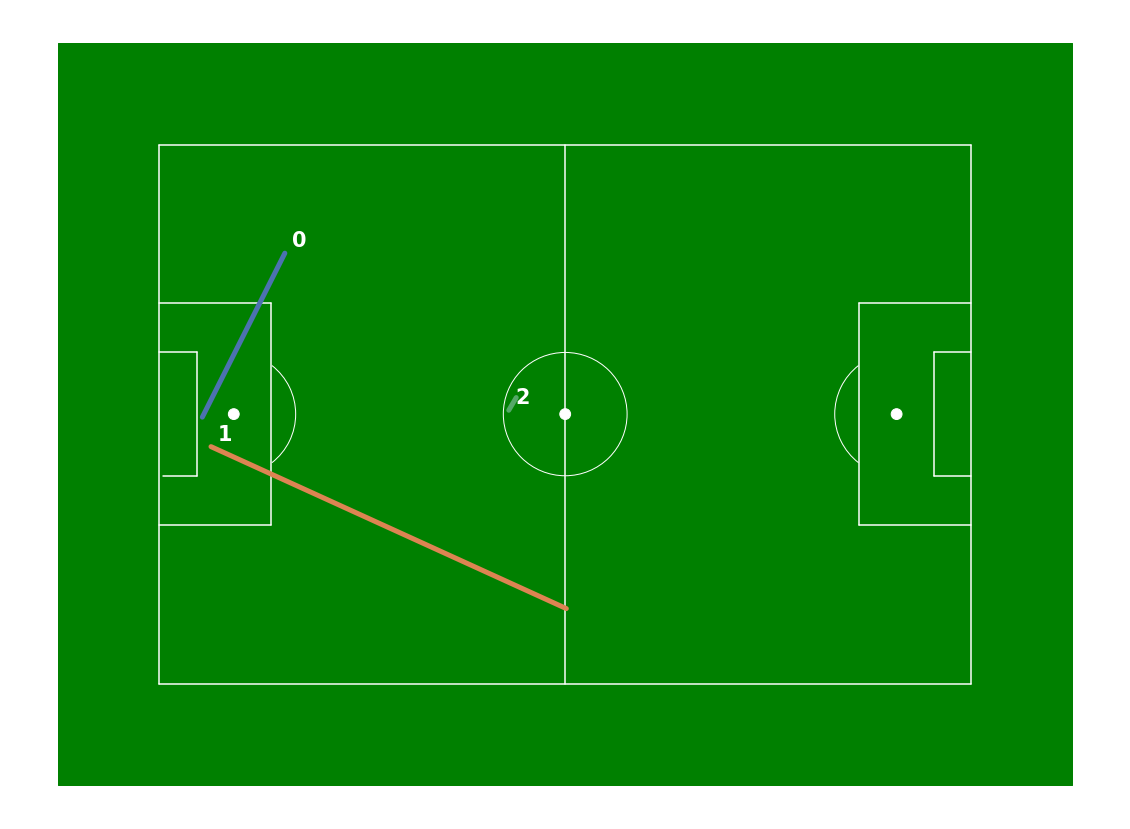

In [122]:
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_wales.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 5)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig("dbscan_cluster_wales.png")

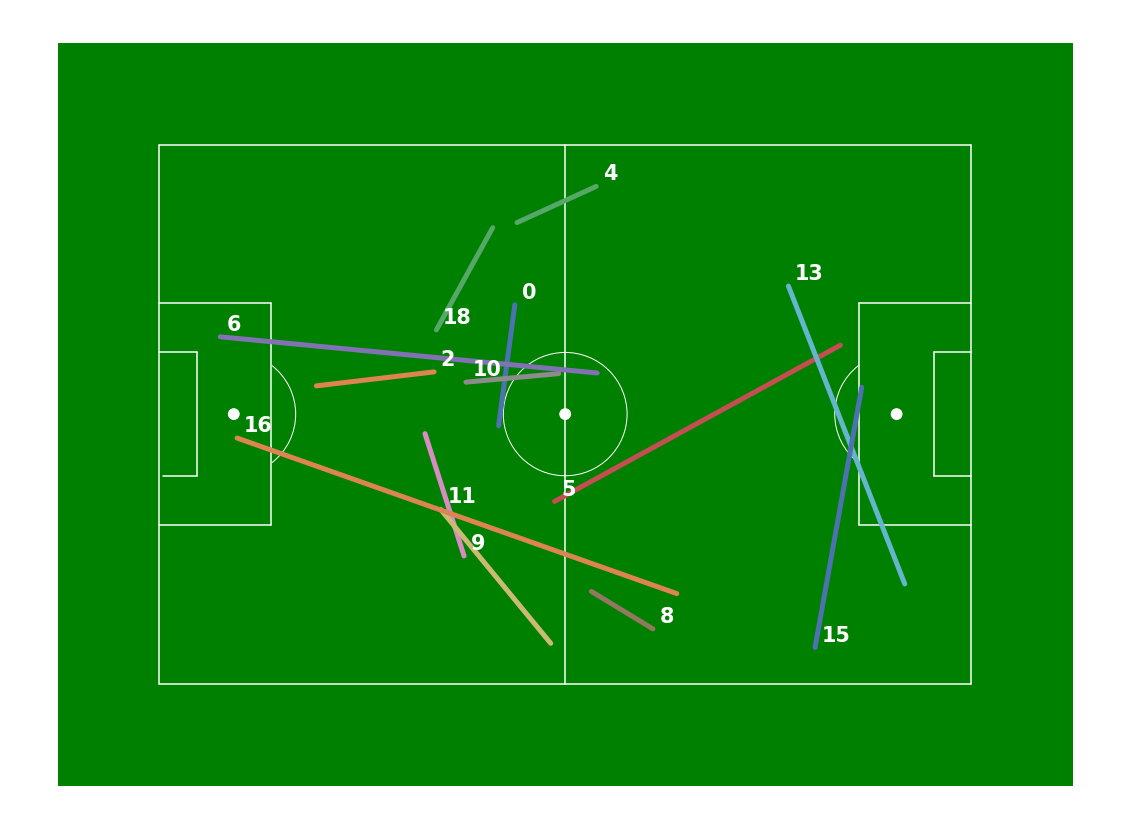

In [123]:
clusters_wales2 = wpasses.groupby('gmm_cluster').mean()[cluster_cols]
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_wales2.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    plt.plot([x, end_x], [y, end_y], linewidth = 5)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large')
    plt.savefig("dbscan_cluster_wales.png")

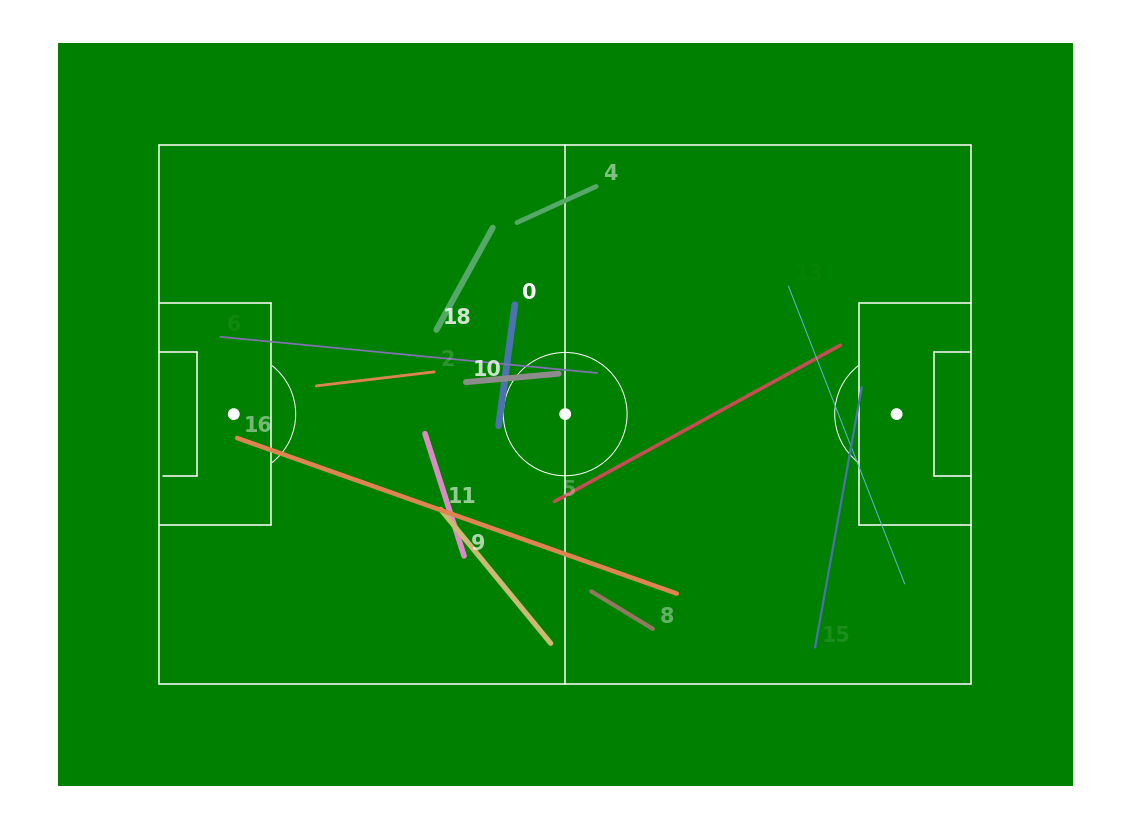

In [124]:
clusters_wales2['size'] = wpasses.groupby('gmm_cluster').size()
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in clusters_wales2.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    color = 'blue' 
    y = 80 - y
    end_y = 80 - end_y
    lwidth = np.sqrt(pass_['size'])
    plt.plot([x, end_x], [y, end_y], linewidth = lwidth)
    plt.text((x+1),y+1,index, color = "white", fontweight = 'bold', fontsize = 'xx-large', alpha = pass_['size'] / clusters_wales2['size'].max())
    plt.savefig('gmm_cluster_size.png')

In [125]:
wpasses.groupby('gmm_cluster')['pass_length'].mean()

gmm_cluster
0     19.757254
2     20.722548
4     15.443989
5     54.548643
6     56.198099
8     12.751537
9     21.162040
10    14.885201
11    26.570731
13    47.428684
15    40.958025
16    69.317140
18    18.561482
Name: pass_length, dtype: float64

In [126]:
wpasses['gmm_cluster'].value_counts()

0     46
18    37
10    36
9     31
11    27
4     23
16    21
8     18
5     13
2      8
15     5
6      3
13     1
Name: gmm_cluster, dtype: int64

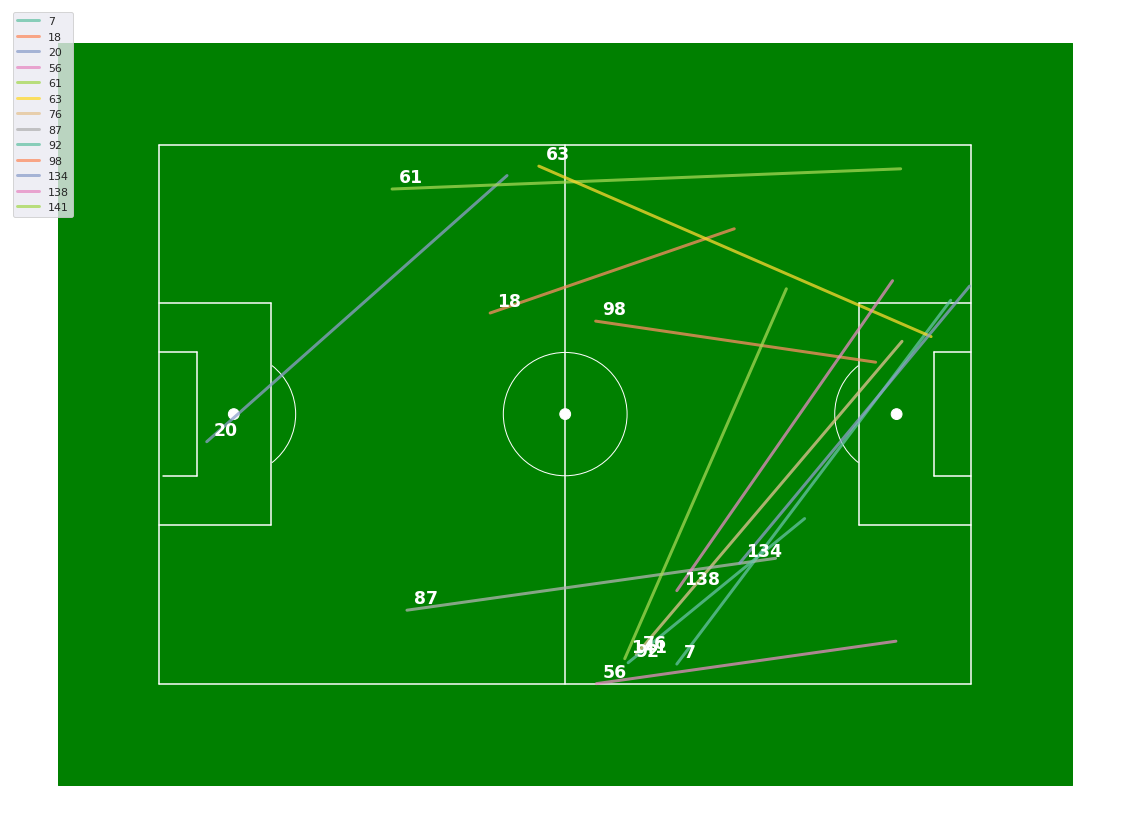

In [127]:
cluster5 = wpasses[(wpasses['gmm_cluster'] == 5)]
color_labels = cluster5.possession.unique()
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))
fig, ax = create_pitch(120, 80,'white')
for index, pass_ in cluster5.iterrows():
    if (index < 0):
        continue
    x, y = pass_['x'], pass_['y']
    end_x, end_y = pass_['end_x'], pass_['end_y']
    y = 80 - y
    end_y = 80 - end_y
    color = color_map[pass_['possession']]
    ax.plot([x, end_x], [y, end_y], linewidth = 3, alpha = 0.75, color = color)
    plt.text((x+1),y+1,pass_.possession, color = "white", fontweight = 'bold', fontsize = 'x-large')


for c in color_labels:
    ax.plot(x, y, linewidth = 3, color = color_map[c], alpha = 0.75, label = c)
ax.legend(loc = 'upper left')

plt.savefig('cluster5_gmm_play.png')